In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm.notebook import tqdm_notebook as tqdm
tqdm.pandas()

In [218]:
os.chdir('C:/Users/wissam_T/Desktop/5th/2nd semester/ml + dm')

In [219]:
og_vehicles_df = pd.read_csv("data/vehicles.csv")   

In [4]:
og_vehicles_df.head()

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
0,7222695916,https://prescott.craigslist.org/cto/d/prescott...,prescott,https://prescott.craigslist.org,6000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN,NaN
1,7218891961,https://fayar.craigslist.org/ctd/d/bentonville...,fayetteville,https://fayar.craigslist.org,11900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN,NaN
2,7221797935,https://keys.craigslist.org/cto/d/summerland-k...,florida keys,https://keys.craigslist.org,21000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN,NaN,NaN
3,7222270760,https://worcester.craigslist.org/cto/d/west-br...,worcester / central MA,https://worcester.craigslist.org,1500,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN,NaN,NaN
4,7210384030,https://greensboro.craigslist.org/cto/d/trinit...,greensboro,https://greensboro.craigslist.org,4900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN,NaN,NaN


In [220]:
from sklearn.model_selection import train_test_split

# Test being the final testing data
train_val, test = train_test_split(og_vehicles_df, test_size=0.2, random_state=42)

In [221]:
#train is the data we will work on
#val is the data we will validate on before testing
train, val = train_test_split(train_val, test_size=0.2, random_state=42)

In [222]:
train_X = train.drop('price', axis=1) 
train_y = train['price']

In [223]:
cols_to_drop = ['id', 'url', 'region_url', 'county', 'image_url', 'posting_date', 'VIN']

In [224]:
train_copy = train_X.copy()

In [225]:
train_copy = train_copy.drop(columns = cols_to_drop)

In [226]:
def null_with_percentage(dataframe):
    null_counts = dataframe.isnull().sum()
    null_percentages = (dataframe.isnull().sum() / len(dataframe)) * 100
    
    null_analysis = pd.DataFrame({
        'Null Count': null_counts,
        'Null Percentage': null_percentages
    }).sort_values(by='Null Percentage', ascending=False)
    
    print("Null Value Counts and Percentages per Column:")
    print(null_analysis)
    print("\n" + "="*70 + "\n")

# filling null values using the model column 

In [227]:
# Step 1: Group by model and calculate mode (most common values) for categorical columns
model_based_fill = train_copy.groupby('model').agg({
    'manufacturer': lambda x: x.mode()[0] if not x.mode().empty else np.nan,
    'cylinders': lambda x: x.mode()[0] if not x.mode().empty else np.nan,
    'fuel': lambda x: x.mode()[0] if not x.mode().empty else np.nan,
    'transmission': lambda x: x.mode()[0] if not x.mode().empty else np.nan,
    'drive': lambda x: x.mode()[0] if not x.mode().empty else np.nan,
    'size': lambda x: x.mode()[0] if not x.mode().empty else np.nan,
    'type': lambda x: x.mode()[0] if not x.mode().empty else np.nan,
    'year': lambda x: x.mode()[0] if not x.mode().empty else np.nan,    
}).reset_index()

# Step 2: Merge with original data to fill nulls
for col in ['manufacturer', 'cylinders', 'fuel',
           'transmission', 'drive', 'size', 'type', 'year']:
    train_copy[col] = train_copy[col].fillna(train_copy.merge(model_based_fill, on='model', how='left')[f'{col}_y'])

In [12]:
train_copy.isna().sum()

region               0
year               129
manufacturer      4173
model             3363
condition       111496
cylinders        49026
fuel               811
odometer          2852
title_status      5262
transmission       613
drive            32349
size             99209
type             21947
paint_color      83422
description         50
state                0
lat               4135
long              4135
dtype: int64

In [13]:
train.isna().sum()

id                   0
url                  0
region               0
region_url           0
price                0
year               784
manufacturer     11267
model             3363
condition       111496
cylinders       113755
fuel              1895
odometer          2852
title_status      5262
transmission      1613
VIN             103167
drive            83590
size            196012
type             59646
paint_color      83422
image_url           49
description         50
county          273203
state                0
lat               4135
long              4135
posting_date        49
dtype: int64

In [14]:
electric_cars_df = train_copy[train_copy['fuel'] == 'electric']

In [15]:
electric_cars_df.isna().sum()

region            0
year              0
manufacturer     15
model             1
condition       363
cylinders       374
fuel              0
odometer          4
title_status     18
transmission      5
drive            71
size            426
type             31
paint_color     303
description       0
state             0
lat              20
long             20
dtype: int64

# Since electric vehicles dont have cylinders we'll just put "0" in the column

In [16]:
train_copy.loc[train_copy['fuel'] == 'electric', 'cylinders'] = 0

In [17]:
train_copy.isna().sum()

region               0
year               129
manufacturer      4173
model             3363
condition       111496
cylinders        48652
fuel               811
odometer          2852
title_status      5262
transmission       613
drive            32349
size             99209
type             21947
paint_color      83422
description         50
state                0
lat               4135
long              4135
dtype: int64

# We'll make a word cloud to see what kind of words are mostly repeated in the description column, so that maybe we can use it to fill some of the null values

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = ' '.join(train_copy['description'].dropna().astype(str).tolist())

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Common Words in Descriptions")
plt.show()

In [338]:
class CarPreprocessor:
    def __init__(self):
        # Initialize any mappings or regex patterns here
        self.mileage_patterns = [
            # Standard patterns
            r'(\d{1,3}(?:,\d{3})*)\s*miles',  # 85,000 miles
            r'(\d{1,3}(?:,\d{3})*)\s*mi',     # 120,000 mi
            r'(\d+)\s*k\s*miles',              # 120k miles
            r'(\d+)\s*k\s*mi',                 # 85k mi
            r'(\d+)\s*k\b',                    # 120k
            
            # Enhanced patterns
            r'mileage:\s*(\d{1,3}(?:,\d{3})*)',
            r'odometer:\s*(\d{1,3}(?:,\d{3})*)',
            r'\b(\d{3})\s*k\b',                # 150k (3-digit)
            r'(\d+)\s*thousand\s*miles',
            r'(\d+)\s*kmiles',                 # 150kmiles
            r'(\d+)\s*,\s*(\d{3})\s*miles',    # 12,345 miles (capture both groups)
            r'approx\s*(\d+)\s*k',             # approx 120k
            r'~(\d+)\s*k',                     # ~120k
            r'around\s*(\d+)\s*k\s*miles',
            r'original\s*miles:\s*(\d+)',
            r'actual\s*miles:\s*(\d+)',
            r'\b(\d+)km?\b',                   # European style 150k
            r'(\d+)\s*[km]?\s*(?:miles|mi)',
            
            # German/European variants
            r'(\d{1,3}(?:\.\d{3})*\s*km)',    # 85.000 km
            r'(\d+)\s*tkm'                     # 150tkm (German thousands)
        ]
        self.transmission_map = {
        'automatic': [
            'auto', 'automatic', 'a/t', 'at', 'shiftless', 'self-shifting',
            'triptonic', 'steptronic', 'automanual', 'manumatic',
            'dual clutch', 'dsg', 'pdks', 's tronic', 'dct', 'speedshift',
            'powershift', 'multitronic', 'tiptronic', 'sportronic'
        ],
        'manual': [
            'manual', 'stick', 'm/t', 'mt', 'standard', '4-speed', '5-speed',
            '6-speed', 'clutch', 'h-pattern', 'floor shift', 'column shift',
            '3-pedal', 'three pedal', 'shift your own'
        ],
        'cvt': [
            'cvt', 'continuously variable', 'varitronic', 'xtronic',
            'ecvt', 'ivt', 'smartshift', 'hypertronic'
        ],
        'automated_manual': [
            'automated manual', 'amt', 'e-clutch', 'semi-auto',
            'clutchless manual', 'sequential'
        ],
        'other': [
            'direct drive', 'single speed', 'preselector', 'hydrostatic',
            'ivtm', 'torque converter'
        ]
    }
        self.drive_map = {
        'fwd': [
            'front wheel', 'fwd', 'front drive', '2wd', 'two wheel',
            'front-wheel', 'f.w.d.', 'f w d', 'forward wheel'
        ],
        'rwd': [
            'rear wheel', 'rwd', 'rear drive', '2wd', 'two wheel',
            'rear-wheel', 'r.w.d.', 'r w d', 'back wheel'
        ],
        'awd': [
            'all wheel', 'awd', '4matic', 'quattro', 'xdrive', 'sh-awd',
            '4motion', 'symmetrical awd', 'super handling awd', 's-awd',
            'torque vectoring', 'torsen', 'haldex', 'on-demand', 'full-time 4wd',
            'permanent 4wd', '4matic+', 'quattro ultra', 'dynamic torque vectoring'
        ],
        '4wd': [
            'four wheel', '4wd', '4x4', 'part-time 4wd', 'selectable 4wd',
            'shift-on-the-fly', '4 wheel drive', '4-wheel', 'four-by-four',
            '4 wd', '4 by 4', '4x4 system', '4x4 drivetrain'
        ],
        'unknown': [
            'unspecified', 'unknown', 'not specified', '?'
        ]}
        self.color_map = defaultdict(list, {
        'white': [
            'white', 'pearl', 'ivory', 'alabaster', 'chalk', 'coconut', 'diamond',
            'frost', 'glacier', 'moonstone', 'opal', 'seashell', 'snow', 'whisper',
            'cream', 'eggshell', 'vanilla', 'porcelain', 'pearl white', 'triple white'
        ],
        'black': [
            'black', 'onyx', 'ebony', 'obsidian', 'phantom', 'raven', 'sable',
            'shadow', 'vader', 'midnight', 'cosmic', 'licorice', 'piano', 'tuxedo',
            'jet', 'carbon', 'graphite', 'black sapphire', 'black noir'
        ],
        'silver': [
            'silver', 'platinum', 'metallic gray', 'brushed metal', 'steel',
            'chrome', 'argent', 'polished', 'mercury', 'moonlight silver'
        ],
        'gray': [
            'gray', 'grey', 'graphite', 'charcoal', 'ash', 'slate', 'stone',
            'cement', 'granite', 'smoke', 'pewter', 'storm', 'concrete', 'titanium'
        ],
        'red': [
            'red', 'ruby', 'burgundy', 'cherry', 'scarlet', 'maroon', 'crimson',
            'garnet', 'fire red', 'candy apple', 'vermilion', 'blood red', 'wine'
        ],
        'blue': [
            'blue', 'navy', 'sapphire', 'aqua', 'teal', 'cobalt', 'sky blue',
            'midnight blue', 'turquoise', 'steel blue', 'indigo', 'denim', 'arctic'
        ],
        'green': [
            'green', 'emerald', 'forest', 'lime', 'mint', 'olive', 'jade',
            'army green', 'seafoam', 'moss', 'avocado', 'sage', 'pine'
        ],
        'brown': [
            'brown', 'tan', 'bronze', 'copper', 'champagne', 'beige', 'mocha',
            'chocolate', 'espresso', 'cinnamon', 'pecan', 'rust', 'caramel', 'nutmeg'
        ],
        'gold': [
            'gold', 'amber', 'honey', 'topaz', 'saffron', 'sunstone', 'champagne gold'
        ],
        'yellow': [
            'yellow', 'mustard', 'lemon', 'sunflower', 'banana', 'dandelion',
            'canary', 'butter'
        ],
        'orange': [
            'orange', 'tangerine', 'coral', 'amber orange', 'burnt orange',
            'copper orange', 'pumpkin', 'sunset'
        ],
        'purple': [
            'purple', 'violet', 'plum', 'lavender', 'amethyst', 'orchid',
            'grape', 'wine purple', 'deep purple'
        ],
        'custom': [
            'matte', 'metallic', 'chrome', 'primer', 'wrapped', 'plasti-dip',
            'color changing', 'chameleon', 'two-tone', 'murdered out', 'stealth',
            'patina', 'rat rod', 'primer gray', 'custom paint', 'graphics',
            'wrap', 'fade', 'flip-flop', 'iridescent'
        ]
    })
        self.vehicle_type_map = {
        'sedan': [
            'sedan', 'saloon', '4-door', 'four door', 'notchback', 'fastback',
            'hardtop', 'post sedan', 'club sedan', 'berline', 'limousine'
        ],
        'SUV': [
            'suv', 'sport utility', 'crossover', 'jeep', 'xuv', 'sav', 'sport activity',
            'soft-roader', 'off-road', '4x4', 'high rider', 'raised', 'command driving',
            'urban cruiser'
        ],
        'truck': [
            'truck', 'pickup', 'pick-up', 'ute', 'dual cab', 'single cab', 'crew cab',
            'flatbed', 'dumper', 'box truck', 'haul truck', 'lifted truck',
            'work truck', 'chassis cab', 'trailering', 'utility truck'
        ],
        'coupe': [
            'coupe', 'coupé', '2-door', 'two door', 'sport coupe', 'notchback coupe',
            'performance coupe'
        ],
        'hatchback': [
            'hatchback', 'hatch', '3-door', '5-door', 'liftback', 'compact hatch',
            'hot hatch'
        ],
        'wagon': [
            'wagon', 'estate', 'touring', 'sport wagon', 'station wagon', 'longroof',
            'shooting brake', 'family wagon'
        ],
        'van': [
            'van', 'minivan', 'mpv', 'passenger van', 'cargo van', 'work van',
            'sprinter', 'panel van', 'shuttle van', 'family van', 'transit'
        ],
        'convertible': [
            'convertible', 'cabriolet', 'roadster', 'drop-top', 'soft top', 'ragtop',
            'open top', 'spyder', 'volante'
        ],
        'exotic': [
            'supercar', 'hypercar', 'exotic', 'gt', 'grand tourer', 'spider',
            'barchetta', 'speedster', 'targa', 'lambo', 'ferrari', 'rare import'
        ],
        'other': [
            'buggy', 'dune buggy', 'motorhome', 'rv', 'golf cart', 'side-by-side',
            'atv', 'utv', 'kart', 'classic', 'kit car'
        ]
    }
        self.size_patterns = [
        # Subcompact and Mini
        (r'\bsub[\s\-]?compact\b', 'subcompact'),
        (r'\bmini\b', 'subcompact'),
        (r'\bmicro\b', 'subcompact'),
        (r'\bkei car\b', 'subcompact'),
        (r'\bcity car\b', 'subcompact'),
        (r'\btiny\b', 'subcompact'),
        (r'\bvery small\b', 'subcompact'),
    
        # Compact
        (r'\bcompact\b', 'compact'),
        (r'\bsmall\b', 'compact'),
        (r'\b5[\s\-]?door hatch\b', 'compact'),
        (r'\bcompact suv\b', 'compact'),
        (r'\bentry level\b', 'compact'),
    
        # Mid-size
        (r'\bmid[\s\-]?size\b', 'mid-size'),
        (r'\bintermediate\b', 'mid-size'),
        (r'\bmedium\b', 'mid-size'),
        (r'\bstandard\b', 'mid-size'),
        (r'\baverage size\b', 'mid-size'),
        (r'\bmidsize suv\b', 'mid-size'),
    
        # Full-size
        (r'\bfull[\s\-]?size\b', 'full'),
        (r'\blarge\b', 'full'),
        (r'\bexecutive\b', 'full'),
        (r'\bfamily size\b', 'full'),
        (r'\bfull size truck\b', 'full'),
        (r'\boversized\b', 'full'),
    
        # Extra large / extended
        (r'\bxl\b', 'extra-large'),
        (r'\bextra[\s\-]?large\b', 'extra-large'),
        (r'\bextended\b', 'extra-large'),
        (r'\blwb\b', 'extra-large'),  # Long wheelbase
        (r'\bcrew cab\b', 'extra-large'),
        (r'\bmega cab\b', 'extra-large'),
    
        # Engine displacement (proxy for size)
        (r'\b\d\.\d\s*l\b', 'large'),
        (r'\b\d{1,2}\s*valve\b', 'large'),
        (r'\bv[\-]?\d\b', 'large'),
        (r'\b(v6|v8|v10|v12)\b', 'large'),
    
        # Marketing classes
        (r'\bfull[\s\-]?sized luxury\b', 'full'),
        (r'\bcompact crossover\b', 'compact'),
        (r'\bmini[\s\-]?suv\b', 'subcompact'),
        (r'\bmidsize crossover\b', 'mid-size'),
        (r'\bthree[-\s]?row\b', 'extra-large'),
        ]
        self.cylinder_patterns = [
        (r'\b(v\d)\b', lambda m: f"{m.group(1)[1]} cylinders"),  # V6
        (r'\b(\d)\s*(?:cyl|cylinder)s?\b', lambda m: f"{m.group(1)} cylinders"),  # 4 cyl
        (r'\b(\d)\s*[\-]?speed\b', lambda m: f"{m.group(1)} cylinders" if int(m.group(1)) in [4,6,8] else None),
        (r'\b(\d\.\d)L\b', lambda m: '6 cylinders' if float(m.group(1)) >= 3.0 else '4 cylinders'),
        (r'\b(\d)\s*[\-]pot\b', lambda m: f"{m.group(1)} cylinders"),  # 6-pot
        (r'\b(i\d)\b', lambda m: f"{m.group(1)[1]} cylinders"),  # I4
        (r'\b(rotary|wankel)\b', lambda m: 'rotary'),
        (r'\b(b\d+)\b', lambda m: f"{m.group(1)[1:]} cylinders"),  # B58 → 8
        (r'\b(n\d+)\b', lambda m: f"{m.group(1)[1:]} cylinders"),  # N55 → 6
        (r'\b(ls\d+)\b', lambda m: '8 cylinders'),  # LS engines are V8s
        (r'\b(rb\d+)\b', lambda m: '6 cylinders'),  # RB series are I6
        (r'\b(1uz|2uz|3uz)\b', lambda m: '8 cylinders'),  # Toyota UZ series
        (r'\b(k\d+[a-z]*)\b', lambda m: '4 cylinders'),  # K20, K24 are I4
        (r'\b(ej\d+)\b', lambda m: '4 cylinders'),  # Subaru EJ series
        (r'\b(sr\d+[a-z]*)\b', lambda m: '4 cylinders'),  # SR20DET etc
        (r'\b(13b|20b)\b', lambda m: 'rotary'),  # Mazda rotary
        (r'\b(v\d)\b', lambda m: f"{m.group(1)[1]} cylinders"),  # V6
        (r'\b(i\d)\b', lambda m: f"{m.group(1)[1]} cylinders"),  # I4
        (r'\b(\d)\s*cyl\b', lambda m: f"{m.group(1)} cylinders"),
        (r'\b(\d)\s*pot\b', lambda m: f"{m.group(1)} cylinders"),  # 6-pot
        (r'\b(\d)\s*spd\b', lambda m: f"{m.group(1)} cylinders" if int(m.group(1)) in [4, 6, 8] else None),
        (r'\b(b\d+)\b', lambda m: f"{m.group(1)[1:]} cylinders"),  # B58 → 8
        (r'\b(n20|n55)\b', lambda m: '4 cylinders' if m.group(1)[1:] == '20' else '6 cylinders'),
        (r'\b(ls\d)\b', lambda m: '8 cylinders'),  # LS engines
        (r'\b(2jz|7m)\b', lambda m: '6 cylinders'),  # Toyota engines
        (r'\b(rb\d+)\b', lambda m: '6 cylinders'),  # Nissan RB series
        (r'\b(13b|20b)\b', lambda m: 'rotary')  # Mazda rotary
        ]
        self.fuel_map = {
        'gas': ['gas', 'gasoline', 'petrol'],
        'diesel': ['diesel'],
        'electric': ['electric', 'ev'],
        'hybrid': ['hybrid', 'plug-in hybrid', 'phev'],
        'other': ['flex fuel', 'ethanol', 'lpg']
        }
        self.brands = ['toyota', 'honda', 'ford', 'chevrolet', 'chevy', 'nissan', 'bmw', 'mercedes', 'mazda', 'jeep',
              'subaru', 'hyundai', 'kia', 'audi', 'vw', 'volkswagen', 'dodge', 'ram', 'gmc', 'lexus', 'chrysler']
        self.condition_map = {
        # New / Like New
        'new': [
            'brand new', 'factory new', 'showroom new', 'never driven', 
            'zero miles', '0 miles', 'still in wrapper', 'with tags',
            'never titled', 'dealer fresh'
        ],
        'like new': [
            'like new', 'as new', 'near new', 'basically new', 'almost new',
            'barely used', 'gently used', 'lightly used', 'hardly used',
            'looks new', 'appears new', 'mint condition', 'pristine',
            'used but looks new', 'perfect condition'
        ],
        
        # Excellent
        'excellent': [
            'excellent', 'exceptional', 'immaculate', 'flawless', 'showroom quality',
            'well maintained', 'serviced regularly', 'garage kept', 'adult owned',
            'no issues', 'no problems', 'runs perfect', 'mechanically sound',
            'clean inside out', 'no accidents', 'no damage', 'no dents',
            'no scratches', 'no rust'
        ],
        
        # Good
        'good': [
            'good', 'good condition', 'runs good', 'runs great', 'drives well',
            'solid condition', 'minor wear', 'normal wear', 'well cared for',
            'maintained', 'some wear', 'age appropriate', 'nice condition',
            'clean title', 'no major issues', 'minor cosmetic', 'small scratches',
            'few dings'
        ],
        
        # Fair
        'fair': [
            'fair', 'fair condition', 'average condition', 'needs some work',
            'minor issues', 'cosmetic issues', 'runs but needs', 'requires tlc',
            'mechanically ok', 'body issues', 'interior wear', 'high miles',
            'mileage wear', 'old but runs', 'used daily', 'project car',
            'could use', 'peeling paint', 'faded'
        ],
        
        # Salvage / Poor
        'salvage': [
            'salvage', 'rebuilt', 'reconstructed', 'total loss', 'insurance loss',
            'flood car', 'water damage', 'hail damage', 'frame damage',
            'mechanical issues', 'engine problems', 'transmission issues',
            'doesn\'t run', 'won\'t start', 'for parts', 'parts only',
            'non-op', 'non operational', 'project only', 'needs engine',
            'needs transmission', 'needs repair', 'as is', 'junk title',
            'scrap', 'not drivable'
        ],
        
        # Special Cases
        'certified': [
            'certified', 'cpo', 'manufacturer certified', 'dealer certified',
            'warranty', 'extended warranty'
        ],
        'modified': [
            'modified', 'custom', 'upgraded', 'aftermarket', 'performance parts',
            'turbocharged', 'supercharged', 'built engine', 'stance', 'lowered',
            'lifted', 'big tires'
        ]}
        self.year_patterns = [
        # Priority patterns (most specific first)
        r'\bmy\s*(\d{4})\b',  # MY2015
        r'\bmfg\s*[:\.]?\s*(\d{4})',  # MFG:2010
        r'\bmodel\s*year\s*[:\.]?\s*(\d{4})',
        r'\bmanufactured\s*[:\.]?\s*(\d{4})',
        r'\bfirst\s*registered\s*[:\.]?\s*(\d{4})',
        r'\bproduction\s*date\s*[:\.]?\s*(\d{4})',
        r'\bbuilt\s*[:\.]?\s*(\d{4})',
        
        # General patterns
        r'\b(19[5-9]\d|20[0-3]\d|202[4-5])\b',  # Standard years
        r'\b(?:yr|year)\s*[:\.]?\s*(\d{4})',
        r'\b(?:early|late)\s*(\d{4})s?',  # early 2000s
        r'\b(\d{4})\s*model\b',
        r'\b(\d{4})\s*-\s*(\d{4})\b'  # Year ranges
        ]
        self.engine_size_map = {
        '1.0L': '3 cylinders', '1.2L': '3 cylinders',
        '1.4L': '4 cylinders', '1.5L': '4 cylinders',
        '1.6L': '4 cylinders', '1.8L': '4 cylinders',
        '2.0L': '4 cylinders', '2.4L': '4 cylinders',
        '2.5L': '4 cylinders', '3.0L': '6 cylinders',
        '3.5L': '6 cylinders', '4.0L': '8 cylinders',
        '5.0L': '8 cylinders', '6.0L': '12 cylinders'
        }
        self.type_cylinder_map = {
        'sedan': '4 cylinders',
        'compact': '4 cylinders',
        'coupe': '6 cylinders',
        'SUV': '6 cylinders',
        'truck': '8 cylinders',
        'van': '6 cylinders',
        'convertible': '6 cylinders',
        'hatchback': '4 cylinders'
        }
        self.manufacturer_defaults = {
            'toyota': '4 cylinders',
            'ford': '6 cylinders',
            'bmw': '4 cylinders',
            'chevrolet': '8 cylinders',
        }
        self.    ev_makes = {
        'tesla', 'rivian', 'lucid', 'fisker', 'polestar', 
        'nio', 'xpeng', 'li auto', 'byton', 'faraday future'
        }
        # Model patterns indicating EVs
        self.ev_model_patterns = [
        r'\be-?\d',                # e-tron, e6, e-golf
        r'\bvolt\b',               # Chevy Volt
        r'\bbolt\b',               # Chevy Bolt
        r'\bleaf\b',               # Nissan Leaf
        r'\bion(?:iq)?\b',         # Hyundai Ioniq/Ioniq5
        r'\bev\b',                 # Model EV
        r'\belectr',               # Electric, Electra
        r'\bphev\b',               # Plug-in Hybrid
        r'\bzoe\b',                # Renault Zoe
        r'\bmodel [s3xy]',         # Tesla Models
        r'\bid\b',                 # VW ID.4
        r'\b(?:\d+)i\b',           # BMW i3, i8
        r'\bmirai\b',              # Toyota Mirai
        r'\bmustang mach-e\b',     # Ford Mustang Mach-E
        ]
        # Description keywords
        self.ev_desc_keywords = [
            'electric vehicle', 'zero emission', 'battery powered',
            'ev range', 'kwh battery', 'plug in', 'charger included',
            'supercharger', 'wall connector'
        ]
        self._progress = None  # Will hold our progress bar reference
        
        
    def preprocess(self, df):
        """Main preprocessing pipeline with consistent progress bars"""
        # Initialize ONE main progress bar
        total_steps = 7  # Update this if steps change
        main_progress = tqdm(total=total_steps, 
                            desc="Overall Progress", 
                            position=0,  # Critical for proper spacing
                            leave=True,
                            bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]',
                            ncols=100)
        
        try:
            df = df.copy()
            
            # Step 1: Column dropping
            main_progress.set_description("Dropping columns")
            cols_to_drop = ['id', 'url', 'region_url', 'county', 'image_url', 'posting_date', 'VIN', 'region']
            df = df.drop(columns=cols_to_drop, errors='ignore')
            main_progress.update(1)
            
            # Step 2: Fill nulls
            main_progress.set_description("Filling model info")
            df = self.filling_nulls_from_other_rows_model_info(df)
            main_progress.update(1)
            
            # Step 3: Feature extraction
            main_progress.set_description("Extracting features")
            df = self._extract_features_with_progress(df, main_progress)
            
            # Step 4: Geocoding
            main_progress.set_description("Geocoding")
            df = self.fill_lat_lon_by_state(df)
            df = df.drop(columns=['state'], errors='ignore')
            main_progress.update(1)
            
            # Step 5: outlayer odometer value handling
            main_progress.set_description("handling utlayer odometer values")
            df = self.handle_outliers(df)
            main_progress.update(1)

            
            # Remaining steps
            steps = [
                (self._process_electric_vehicles, "Processing EVs"),
                (self._process_cylinders, "Processing cylinders"),
                (self._process_conditions, "Processing conditions"),
                (self._final_cleaning, "Final cleaning")
            ]
            
            for func, desc in steps:
                main_progress.set_description(desc)
                df = func(df)
                main_progress.update(1)
                
            return df
        finally:
            main_progress.close()


    def _extract_features_with_progress(self, df, main_progress):
        """Feature extraction with sub-progress that doesn't conflict"""
        columns_to_fill = [
            'odometer', 'transmission', 'drive', 'paint_color',
            'type', 'size', 'cylinders', 'fuel', 'manufacturer',
            'year', 'condition'
        ]
        
        with tqdm(total=len(columns_to_fill), desc="Extracting features") as sub_progress:
            for column in columns_to_fill:
                mask = df[column].isna()
                df.loc[mask, column] = df[mask].progress_apply(
                    lambda row: self.safe_extract(row, column),
                    axis=1
                )
                sub_progress.update(1)
        
        main_progress.update(1)
        return df
    
    def filling_nulls_from_other_rows_model_info(self, df):
        
        # Step 1: Group by model and calculate mode (most common values) for categorical columns
        model_based_fill = df.groupby('model').agg({
        'manufacturer': lambda x: x.mode()[0] if not x.mode().empty else np.nan,
        'cylinders': lambda x: x.mode()[0] if not x.mode().empty else np.nan,
        'fuel': lambda x: x.mode()[0] if not x.mode().empty else np.nan,
        'transmission': lambda x: x.mode()[0] if not x.mode().empty else np.nan,
        'drive': lambda x: x.mode()[0] if not x.mode().empty else np.nan,
        'size': lambda x: x.mode()[0] if not x.mode().empty else np.nan,
        'type': lambda x: x.mode()[0] if not x.mode().empty else np.nan,
        'year': lambda x: x.mode()[0] if not x.mode().empty else np.nan,    
        }).reset_index()

        # Step 2: Merge with original data to fill nulls
        for column in ['manufacturer', 'cylinders', 'fuel',
                   'transmission', 'drive', 'size', 'type', 'year']:
            df[column] = df[column].fillna(df.merge(model_based_fill, on='model', how='left')[f'{column}_y'])
        
        return df  
    
    def _process_electric_vehicles(self, df):
        """Handle electric vehicle specific processing"""
        # Ensure fuel column exists
        if 'fuel' not in df.columns:
            df['fuel'] = np.nan
            
        # Identify EVs
        ev_mask = self.identify_electric_vehicles(df)
        df.loc[ev_mask, 'fuel'] = 'electric'
        df.loc[ev_mask, 'cylinders'] = 'electric'
        return df
    
    def _process_cylinders(self, df):
        """Process cylinder information"""
        # Ensure required columns exist
        for col in ['cylinders', 'type', 'manufacturer']:
            if col not in df.columns:
                df[col] = np.nan
                
        # Fill missing cylinders
        df = self.fill_cylinders(df)
        
        # Reclassify 'other' cylinders
        mask = df['cylinders'].isin(['other', None, np.nan])
        df.loc[mask, 'cylinders'] = df.loc[mask].apply(
            self.reclassify_other_cylinders,
            axis=1
        )
        
        # Convert to numeric
        df['cylinders_numeric'] = df['cylinders'].apply(
            self.convert_cylinders_to_numeric
        )
        
        valid_cylinder_set = {3, 4, 5, 6, 8, 10, 12, 0}
        df['cylinders_numeric'] = df['cylinders_numeric'].where(
            df['cylinders_numeric'].isin(valid_cylinder_set),
            np.nan
        )
        
        return df
    
    def _process_conditions(self, df):
        """Process vehicle conditions"""
        if 'condition' not in df.columns:
            df['condition'] = np.nan
            
        df = self.estimate_condition_by_mileage(df)
        df = self.fill_condition_with_context(df)
        
        return df
    
    def _final_cleaning(self, df):
        """Final cleaning steps"""
        # Handle EVs
        df['is_electric'] = (df['fuel'] == 'electric').astype(int)
        
        # Clean up
        if 'cylinders' in df.columns:
            df.drop(columns=['cylinders'], inplace=True)
            
        return df
    
    def fill_lat_lon_by_state(self, df):
        """Fill missing lat/long values using the average coordinates per state"""
        # Ensure required columns exist
        if not {'state', 'lat', 'long'}.issubset(df.columns):
            raise ValueError("DataFrame must contain 'state', 'lat', and 'long' columns")
    
        # Compute average lat/lon per state
        state_coords = df.dropna(subset=['lat', 'long']).groupby('state')[['lat', 'long']].mean()
    
        # Create masks for missing values
        missing_lat = df['lat'].isna()
        missing_long = df['long'].isna()
    
        # Fill missing latitudes
        df.loc[missing_lat, 'lat'] = df.loc[missing_lat, 'state'].map(state_coords['lat'])
    
        # Fill missing longitudes
        df.loc[missing_long, 'long'] = df.loc[missing_long, 'state'].map(state_coords['long'])
    
        return df
    
    def _ensure_column_exists(self, df, column, default_value=np.nan):
        if column not in df.columns:
            df[column] = default_value
        return df
        
    def extract_mileage(self, description):
        if pd.isna(description):
            return None
        
        desc = description.lower()
        desc = desc.replace(',', '').replace('.', '')  # Normalize separators
        
        for pattern in mileage_patterns:
            match = re.search(pattern, desc)
            if match:
                try:
                    # Handle multiple capture groups
                    mileage = next((x for x in match.groups() if x is not None))
                    mileage = mileage.replace(',', '').replace('.', '')
                    
                    # Handle k/000 conversion
                    if 'k' in match.group(0).lower() or 'tkm' in match.group(0).lower():
                        return int(mileage) * 1000
                    elif 'thousand' in match.group(0).lower():
                        return int(mileage) * 1000
                    else:
                        return int(mileage)
                except (ValueError, AttributeError):
                    continue
        return None

    def extract_transmission(self, description):
        if pd.isna(description):
            return None
        desc = description.lower()
        for trans_type, keywords in self.transmission_map.items():
            if any(keyword in desc for keyword in keywords):
                return trans_type
        return None

    def extract_drive_type(self, description):
        if pd.isna(description):
            return None
        
        desc = description.lower()
        for drive_type, keywords in self.drive_map.items():
            if any(keyword in desc for keyword in keywords):
                return drive_type
        return None

    def extract_paint_color(self, description):
        if pd.isna(description):
            return None
        
        desc = description.lower()
        for color, variants in self.color_map.items():
            if any(variant in desc for variant in variants):
                return color
        return None
    
    def extract_vehicle_type(self, description):
        if pd.isna(description):
            return None
        desc = description.lower()
        for v_type, keywords in self.vehicle_type_map.items():
            if any(keyword in desc for keyword in keywords):
                return v_type
        return None
    
    def extract_size(self, description):
        if pd.isna(description):
            return None        
    
        desc = description.lower()
        for pattern, size in self.size_patterns:
            if re.search(pattern, desc):
                return size
        return None
    
    def extract_cylinders(self, description):
        if pd.isna(description):
            return None
        desc = description.lower()
        for pattern, converter in self.cylinder_patterns:
            match = re.search(pattern, desc)
            if match:
                try:
                    return converter(match)  # converter returns e.g. '6 cylinders' or integer
                except Exception:
                    continue
        return None
    
    def extract_fuel(self, description):
        if pd.isna(description):
            return None
        
        desc = description.lower()
        for fuel_type, keywords in self.fuel_map.items():
            if any(keyword in desc for keyword in keywords):
                return fuel_type
        return None
    
    def extract_manufacturer(self, description):
        if pd.isna(description):
            return None
        
        desc = description.lower()
        for brand in self.brands:
            if brand in desc:
                if brand == 'chevy':
                    return 'chevrolet'
                elif brand == 'vw':
                    return 'volkswagen'
                else:
                    return brand
        return None
    
    def extract_condition(self, description):
        if pd.isna(description):
            return None
        
        desc = description.lower()
        for cond, keywords in self.condition_map.items():
            if any(kw in desc for kw in keywords):
                return cond
    
        return None
    
    def extract_year(self, description):
        if pd.isna(description):
            return None
        
        desc = description.lower()
        desc = re.sub(r'[^\w\s\.\-]', ' ', desc)  # Clean special chars
        
        for pattern in self.year_patterns:
            match = re.search(pattern, desc)
            if match:
                try:
                    # Handle multiple capture groups (like in year ranges)
                    year_str = next((x for x in match.groups() if x and len(x) == 4))
                    year = int(year_str)
                    # Validate reasonable year range
                    if 1950 <= year <= 2025:
                        return year
                except (ValueError, StopIteration):
                    continue
                    
        return None
    
    @staticmethod
    def safe_extract(row, column):
        try:
            desc = row['description']
            if column == 'odometer':
                return extract_mileage(desc)
            elif column == 'transmission':
                return extract_transmission(desc)
            elif column == 'drive':
                return extract_drive_type(desc)
            elif column == 'paint_color':
                return extract_paint_color(desc)
            elif column == 'type':
                return extract_vehicle_type(desc)
            elif column == 'size':
                return extract_size(desc)
            elif column == 'cylinders':
                return extract_cylinders(desc)
            elif column == 'fuel':
                return extract_fuel(desc)
            elif column == 'manufacturer':
                return extract_manufacturer(desc)
            elif column == 'year':
                return extract_year(desc)
            elif column == 'condition':
                return extract_condition(desc)
            else:
                return None
        except Exception :
            return None
        
    def fill_cylinders(self, df):
        """
        Extract and fill missing 'cylinders' values from multiple sources with confidence scoring.
        Assumes df has columns: 'cylinders', 'description', 'engine_cylinders', 'size_cylinders', 'type', 'manufacturer'
        """
        
        engine_map = df.dropna(subset=['cylinders']).groupby(
        ['manufacturer', 'model', 'year']
        )['cylinders'].agg(
            lambda x: x.mode()[0] if not x.mode().empty else None
        ).reset_index()
        
        # Merge with original data
        df = df.merge(
            engine_map.rename(columns={'cylinders': 'engine_cylinders'}),
            on=['manufacturer', 'model', 'year'],
            how='left'
        )
        
        df['engine_size'] = df['description'].str.extract(r'(\d\.\dL)')[0]
        
        df['size_cylinders'] = df['engine_size'].map(self.engine_size_map)

    
        df['desc_cylinders'] = df['description'].apply(extract_cylinders_from_desc)
        
        # 2. Map cylinders from vehicle type (you need to have this dict defined)
        df['type_cylinders'] = df['type'].map(self.type_cylinder_map)
        
        df['type_cylinders'] = df['type'].map(self.type_cylinder_map)

    
        # 3. Fill cylinders in order of confidence
        df['cylinders'] = (
            df['cylinders']
            .fillna(df['engine_cylinders'])  # Most accurate
            .fillna(df['desc_cylinders'])
            .fillna(df['size_cylinders'])
            .fillna(df['type_cylinders'])
        )
        
        # 4. Fill remaining missing cylinders from manufacturer defaults
        mask_missing = df['cylinders'].isna()
        df.loc[mask_missing, 'cylinders'] = df.loc[mask_missing, 'manufacturer'].map(self.manufacturer_defaults)
        
        # 5. Add confidence score (optional)
        df['cylinders_confidence'] = (
            (~df['engine_cylinders'].isna()).astype(int) * 3 +
            (~df['desc_cylinders'].isna()).astype(int) * 2 +
            (~df['size_cylinders'].isna()).astype(int) * 1
        )
        
        df.drop(['engine_cylinders', 'desc_cylinders', 'size_cylinders', 'desc_cylinders', 'engine_size', 'type_cylinders'], axis=1, inplace=True, errors='ignore')
        
        return df
    
    def handle_outliers(self, df):
        # Consider cars with less than 1,000 or more than 300,000 miles as outliers
        LOWER_BOUND = 1000
        UPPER_BOUND = 600000
        
        Q1 = df['odometer'].quantile(0.25)
        Q3 = df['odometer'].quantile(0.75)
        IQR = Q3 - Q1
        lower_fence = Q1 - 1.5 * IQR
        upper_fence = Q3 + 1.5 * IQR
        
        
        outlier_mask = (df['odometer'] < LOWER_BOUND) | (df['odometer'] > UPPER_BOUND)
        outlier_count = outlier_mask.sum()
    
        df['odometer_outlier'] = outlier_mask.astype(int)
        
        return df
        
    def process_cylinders(self, df):
        """Full cylinder processing pipeline"""
        # Step 1: Clean EVs first
        df = self.clean_ev_cylinders(df)
        
        # Step 2: Extract from descriptions
        df['extracted_cylinders'] = df['description'].apply(self.extract_cylinders)
        
        # Step 3: Fill missing values
        df['cylinders'] = (
            df['cylinders']
            .fillna(df['extracted_cylinders'])
            .fillna(df.groupby(['manufacturer','model'])['cylinders']
                   .transform(lambda x: x.mode()[0] if not x.mode().empty else None))
            .fillna('unknown')
        )
        
        # Step 4: Create numeric version
        df['cylinders_numeric'] = df['cylinders'].apply(
            lambda x: 0 if str(x).startswith('0') else 
                     int(re.search(r'\d+', str(x)).group()) if re.search(r'\d+', str(x)) else 
                     None
        )
    
        return df.drop(columns=['extracted_cylinders'])
    
    def identify_electric_vehicles(self, df):
        # Known 100% EV manufacturers (lowercase for 
        
        # Create boolean masks (with NA handling)
        make_mask = df['manufacturer'].str.lower().fillna('').isin(self.ev_makes)
        
        model_mask = (
            df['model']
            .str.lower()
            .fillna('')
            .str.contains('|'.join(self.ev_model_patterns), regex=True, na=False)
        )
        
        desc_mask = (
            df['description']
            .str.lower()
            .fillna('')
            .str.contains('|'.join(self.ev_desc_keywords), regex=True, na=False)
        )
        
        # Combine conditions
        is_ev = make_mask | model_mask | desc_mask
        
        # Special case handling (override false positives)
        hybrid_exceptions = ['prius prime', 'rav4 prime']
        hybrid_mask = (
            df['model']
            .str.lower()
            .fillna('')
            .isin(hybrid_exceptions)
        )
        is_ev = is_ev & ~hybrid_mask
        
        return is_ev
    
    def estimate_condition_by_mileage(self, df):
        # Define all possible condition categories
        all_conditions = ['new', 'like new', 'excellent', 'good', 'fair', 'salvage', 'commercial']
        
        # Create mileage bins
        bins = [1000, 20000, 50000, 100000, 200000, 300000, 600000, float('inf')]
        labels = ['new', 'like new', 'excellent', 'good', 'fair', 'salvage']
        
        # Ensure odometer is numeric
        df['odometer'] = pd.to_numeric(df['odometer'], errors='coerce')
        
        # Create temporary mileage condition column
        df['mileage_condition'] = pd.cut(
            df['odometer'],
            bins=bins,
            labels=labels,
            right=False
        ).astype('object')  # Convert to object first to avoid categorical issues
        
        # Adjust for vehicle age
        df.loc[(df['year'] >= 2020) & (df['odometer'] <= 50000), 'mileage_condition'] = 'like new'
        
        # Handle commercial vehicles
        commercial_types = ['truck', 'van', 'commercial']
        df.loc[df['type'].isin(commercial_types), 'mileage_condition'] = 'commercial'
        
        # Convert to categorical with all possible categories
        df['mileage_condition'] = pd.Categorical(
            df['mileage_condition'],
            categories=all_conditions,
            ordered=True
        )
              
        return df
        
    def fill_condition_with_context(self, df):
        # Ensure condition column is categorical with all possible categories
        all_conditions = ['new', 'like new', 'excellent', 'good', 'fair', 'salvage', 'commercial']
        df['condition'] = pd.Categorical(
            df['condition'],
            categories=all_conditions,
            ordered=True
        )
        
        # Priority 1: Use existing condition if available
        df['condition'] = df['condition'].fillna(pd.NA)
        
        # Priority 2: Use mileage-based estimate for normal passenger vehicles
        passenger_mask = (~df['type'].isin(['truck', 'van', 'commercial'])) & df['odometer'].notna()
        df.loc[passenger_mask, 'condition'] = df.loc[passenger_mask, 'condition'].fillna(
            df.loc[passenger_mask, 'mileage_condition'].astype('object')  # Convert to object for filling
        )
        
        # Priority 3: For commercial vehicles
        commercial_mask = df['type'].isin(['truck', 'van', 'commercial']) & df['odometer'].notna()
        df.loc[commercial_mask, 'condition'] = df.loc[commercial_mask, 'condition'].fillna(
            'commercial'  # Directly use the string instead of concatenation
        )
        
        # Priority 4: Manufacturer averages
        manufacturer_condition = df.groupby('manufacturer')['condition'].apply(
            lambda x: x.mode()[0] if not x.mode().empty else 'good'
        )
        df['condition'] = df['condition'].fillna(
            df['manufacturer'].map(manufacturer_condition).astype('object')
        )
        
        # Priority 5: Final fallback
        df['condition'] = df['condition'].fillna('good')
        
        # Ensure final type is categorical
        df['condition'] = pd.Categorical(
            df['condition'],
            categories=all_conditions,
            ordered=True
        )
        
        df.drop(columns = ['mileage_condition'], inplace=True, errors='ignore')
        
        return df
        
    # def validate_condition_fills(self, df):
    #     # Add confidence score (1-5)
    #     df['condition_confidence'] = 5  # Highest for original values
    #     df.loc[df['condition'].isna(), 'condition_confidence'] = 0
    # 
    #     # Mileage-based fills get confidence 4
    #     mileage_filled = df['condition'].notna() & df['mileage_condition'].notna()
    #     df.loc[mileage_filled, 'condition_confidence'] = 4
    # 
    #     # Commercial adjustments get confidence 3
    #     df.loc[df['condition'].str.contains('commercial use', na=False), 'condition_confidence'] = 3
    # 
    #     # Manufacturer averages get confidence 2
    #     manu_filled = df['condition'].notna() & (df['condition_confidence'] < 3)
    #     df.loc[manu_filled, 'condition_confidence'] = 2
    # 
    #     # Final fallback gets confidence 1
    #     df.loc[df['condition'] == 'good', 'condition_confidence'] = 1
    # 
    #     # Spot check extremes
    #     high_mileage_new = df[(df['odometer'] > 100000) & (df['condition'] == 'new')]
    #     if not high_mileage_new.empty:
    #         print(f"Warning: {len(high_mileage_new)} high-mileage 'new' vehicles found")
    # 
    #     df.drop(columns = ['mileage_condition'], inplace=True, errors='ignore')
    # 
    #     return df
        
    def clean_ev_cylinders(self, df):
        # Convert cylinders to string type if mixed types exist
        if df['cylinders'].dtype == 'object':
            df['cylinders'] = df['cylinders'].astype(str)
        
        # Standard EV identifiers
        ev_indicators = {
            'fuel': ['electric'],
            'manufacturer': ['tesla', 'rivian', 'lucid', 'polestar', 'nio'],
            'model': ['model s', 'model 3', 'model x', 'model y', 'ev6', 'ioniq'],
            'description': ['zero emission', 'battery electric', 'kwh battery']
        }
        
        # Create comprehensive EV mask
        ev_mask = (
            df['fuel'].str.lower().isin(ev_indicators['fuel']) |
            df['manufacturer'].str.lower().isin(ev_indicators['manufacturer']) |
            df['model'].str.lower().str.contains('|'.join(ev_indicators['model']), na=False) |
            df['description'].str.lower().str.contains('|'.join(ev_indicators['description']), na=False)
        )
        
        # Clean cylinder values
        df.loc[ev_mask, 'cylinders'] = 'electric'
        
        # Find and report any combustion engine terms in EVs
        combustion_terms = r'\b(v\d|i\d|\d[\s-]?cyl|\d[\s-]?liter|l\d)\b'
        evs_with_engine_terms = df[ev_mask & 
                                 df['description'].str.contains(combustion_terms, case=False, na=False)]
        
        if not evs_with_engine_terms.empty:
            print(f"Found {len(evs_with_engine_terms)} EVs with engine terms:")
            print(evs_with_engine_terms[['manufacturer', 'model', 'cylinders', 'description']].head())
        
        return df
    
    def reclassify_other_cylinders(self, row):
        desc = str(row['description']).lower()
        if 'electric' in desc or 'ev' in desc or row['fuel'] == 'electric':
            return 'electric'
        match = re.search(r'\b(\d)[\s-]?(?:cyl|cylinder)', desc)
        if match:
            return f"{match.group(1)} cylinders"
        return 'unknown'  # fallback if still uncertain
    
    def standardize_cylinders(self, value):
        if pd.isna(value):
            return 'unknown'
        val = str(value).lower().strip()
        
        # Merge both electric labels
        if val in ['electric', '0 (electric)']:
            return 'electric'
        
        # Merge None and unknown (after all attempts to extract info are exhausted)
        if val in ['none', 'unknown', 'nan']:
            return 'unknown'
        
        return val  # Keep all other values as-is
    
    def convert_cylinders_to_numeric(self, value):
        if pd.isna(value):
            return np.nan
        val = str(value).lower().strip()
    
        if val == 'electric':
            return 0
        if val == 'unknown':
            return np.nan
    
        match = re.match(r'(\d+)\s*cylinders?', val)
        if match:
            return int(match.group(1))
        
        return np.nan

In [339]:
# Initialize your preprocessor
preprocessor = CarPreprocessor()

# Process the test data
processed_df = preprocessor.preprocess(train_X)

# Display results
print("\n=== Processed Data ===")
print(processed_df[['description', 'odometer', 'fuel', 'cylinders_numeric', 'is_electric', 'condition']])

# Check for remaining missing values
print("\n=== Missing Values ===")
print(processed_df.isna().sum())

Overall Progress:   0%|                                                              | 0/7 [00:00<?]

Extracting features:   0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/2852 [00:00<?, ?it/s]

  0%|          | 0/613 [00:00<?, ?it/s]

  0%|          | 0/32349 [00:00<?, ?it/s]

  0%|          | 0/83422 [00:00<?, ?it/s]

  0%|          | 0/21947 [00:00<?, ?it/s]

  0%|          | 0/99209 [00:00<?, ?it/s]

  0%|          | 0/49026 [00:00<?, ?it/s]

  0%|          | 0/811 [00:00<?, ?it/s]

  0%|          | 0/4173 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/111496 [00:00<?, ?it/s]

ValueError: Bin labels must be one fewer than the number of bin edges

In [ ]:
null_with_percentage(processed_df)

In [325]:
og = processed_df[(processed_df['fuel'] == 'electric') & (processed_df['cylinders_numeric'].notna())]

In [326]:
null_with_percentage(og)

Null Value Counts and Percentages per Column:
                      Null Count  Null Percentage
size                         739         6.666667
title_status                 436         3.933243
drive                        394         3.554353
paint_color                  360         3.247632
type                         173         1.560668
model                         49         0.442039
odometer                      29         0.261615
mileage_condition             28         0.252594
manufacturer                  19         0.171403
lat                            0         0.000000
cylinders_numeric              0         0.000000
cylinders_confidence           0         0.000000
long                           0         0.000000
year                           0         0.000000
description                    0         0.000000
transmission                   0         0.000000
fuel                           0         0.000000
condition                      0         0.000000
is_e

# Using information from the description to fill null values

In [18]:
train_copy['description'].head()

298217                      All wheel drive well maintained
108574    Any year, make, model, and in any condition. W...
69187     Jeep Rubicon---24,216 miles. Probably like you...
168535    Carvana is the safer way to buy a car During t...
16825     Toyota fj 2007 new km2 tires cold a/c 4x4 led ...
Name: description, dtype: object

In [19]:
mileage_patterns = [
    # Standard patterns
    r'(\d{1,3}(?:,\d{3})*)\s*miles',  # 85,000 miles
    r'(\d{1,3}(?:,\d{3})*)\s*mi',     # 120,000 mi
    r'(\d+)\s*k\s*miles',              # 120k miles
    r'(\d+)\s*k\s*mi',                 # 85k mi
    r'(\d+)\s*k\b',                    # 120k
    
    # Enhanced patterns
    r'mileage:\s*(\d{1,3}(?:,\d{3})*)',
    r'odometer:\s*(\d{1,3}(?:,\d{3})*)',
    r'\b(\d{3})\s*k\b',                # 150k (3-digit)
    r'(\d+)\s*thousand\s*miles',
    r'(\d+)\s*kmiles',                 # 150kmiles
    r'(\d+)\s*,\s*(\d{3})\s*miles',    # 12,345 miles (capture both groups)
    r'approx\s*(\d+)\s*k',             # approx 120k
    r'~(\d+)\s*k',                     # ~120k
    r'around\s*(\d+)\s*k\s*miles',
    r'original\s*miles:\s*(\d+)',
    r'actual\s*miles:\s*(\d+)',
    r'\b(\d+)km?\b',                   # European style 150k
    r'(\d+)\s*[km]?\s*(?:miles|mi)',
    
    # German/European variants
    r'(\d{1,3}(?:\.\d{3})*\s*km)',    # 85.000 km
    r'(\d+)\s*tkm'                     # 150tkm (German thousands)
]

def extract_mileage(description):
    if pd.isna(description):
        return None
    
    desc = description.lower()
    desc = desc.replace(',', '').replace('.', '')  # Normalize separators
    
    for pattern in mileage_patterns:
        match = re.search(pattern, desc)
        if match:
            try:
                # Handle multiple capture groups
                mileage = next((x for x in match.groups() if x is not None))
                mileage = mileage.replace(',', '').replace('.', '')
                
                # Handle k/000 conversion
                if 'k' in match.group(0).lower() or 'tkm' in match.group(0).lower():
                    return int(mileage) * 1000
                elif 'thousand' in match.group(0).lower():
                    return int(mileage) * 1000
                else:
                    return int(mileage)
            except (ValueError, AttributeError):
                continue
    return None

In [20]:
def extract_transmission(description):
    if pd.isna(description):
        return None
    transmission_map = {
        'automatic': [
            'auto', 'automatic', 'a/t', 'at', 'shiftless', 'self-shifting',
            'triptonic', 'steptronic', 'automanual', 'manumatic',
            'dual clutch', 'dsg', 'pdks', 's tronic', 'dct', 'speedshift',
            'powershift', 'multitronic', 'tiptronic', 'sportronic'
        ],
        'manual': [
            'manual', 'stick', 'm/t', 'mt', 'standard', '4-speed', '5-speed',
            '6-speed', 'clutch', 'h-pattern', 'floor shift', 'column shift',
            '3-pedal', 'three pedal', 'shift your own'
        ],
        'cvt': [
            'cvt', 'continuously variable', 'varitronic', 'xtronic',
            'ecvt', 'ivt', 'smartshift', 'hypertronic'
        ],
        'automated_manual': [
            'automated manual', 'amt', 'e-clutch', 'semi-auto',
            'clutchless manual', 'sequential'
        ],
        'other': [
            'direct drive', 'single speed', 'preselector', 'hydrostatic',
            'ivtm', 'torque converter'
        ]
    }
    desc = description.lower()
    for trans_type, keywords in transmission_map.items():
        if any(keyword in desc for keyword in keywords):
            return trans_type
    return None

In [22]:
def extract_drive_type(description):
    if pd.isna(description):
        return None
    drive_map = {
    'fwd': [
        'front wheel', 'fwd', 'front drive', '2wd', 'two wheel',
        'front-wheel', 'f.w.d.', 'f w d', 'forward wheel'
    ],
    'rwd': [
        'rear wheel', 'rwd', 'rear drive', '2wd', 'two wheel',
        'rear-wheel', 'r.w.d.', 'r w d', 'back wheel'
    ],
    'awd': [
        'all wheel', 'awd', '4matic', 'quattro', 'xdrive', 'sh-awd',
        '4motion', 'symmetrical awd', 'super handling awd', 's-awd',
        'torque vectoring', 'torsen', 'haldex', 'on-demand', 'full-time 4wd',
        'permanent 4wd', '4matic+', 'quattro ultra', 'dynamic torque vectoring'
    ],
    '4wd': [
        'four wheel', '4wd', '4x4', 'part-time 4wd', 'selectable 4wd',
        'shift-on-the-fly', '4 wheel drive', '4-wheel', 'four-by-four',
        '4 wd', '4 by 4', '4x4 system', '4x4 drivetrain'
    ],
    'unknown': [
        'unspecified', 'unknown', 'not specified', '?'
    ]
    }
    
    desc = description.lower()
    for drive_type, keywords in drive_map.items():
        if any(keyword in desc for keyword in keywords):
            return drive_type
    return None

In [23]:
import re
from collections import defaultdict

# Expanded color dictionary with common variants
color_map = defaultdict(list, {
    'white': [
        'white', 'pearl', 'ivory', 'alabaster', 'chalk', 'coconut', 'diamond',
        'frost', 'glacier', 'moonstone', 'opal', 'seashell', 'snow', 'whisper',
        'cream', 'eggshell', 'vanilla', 'porcelain', 'pearl white', 'triple white'
    ],
    'black': [
        'black', 'onyx', 'ebony', 'obsidian', 'phantom', 'raven', 'sable',
        'shadow', 'vader', 'midnight', 'cosmic', 'licorice', 'piano', 'tuxedo',
        'jet', 'carbon', 'graphite', 'black sapphire', 'black noir'
    ],
    'silver': [
        'silver', 'platinum', 'metallic gray', 'brushed metal', 'steel',
        'chrome', 'argent', 'polished', 'mercury', 'moonlight silver'
    ],
    'gray': [
        'gray', 'grey', 'graphite', 'charcoal', 'ash', 'slate', 'stone',
        'cement', 'granite', 'smoke', 'pewter', 'storm', 'concrete', 'titanium'
    ],
    'red': [
        'red', 'ruby', 'burgundy', 'cherry', 'scarlet', 'maroon', 'crimson',
        'garnet', 'fire red', 'candy apple', 'vermilion', 'blood red', 'wine'
    ],
    'blue': [
        'blue', 'navy', 'sapphire', 'aqua', 'teal', 'cobalt', 'sky blue',
        'midnight blue', 'turquoise', 'steel blue', 'indigo', 'denim', 'arctic'
    ],
    'green': [
        'green', 'emerald', 'forest', 'lime', 'mint', 'olive', 'jade',
        'army green', 'seafoam', 'moss', 'avocado', 'sage', 'pine'
    ],
    'brown': [
        'brown', 'tan', 'bronze', 'copper', 'champagne', 'beige', 'mocha',
        'chocolate', 'espresso', 'cinnamon', 'pecan', 'rust', 'caramel', 'nutmeg'
    ],
    'gold': [
        'gold', 'amber', 'honey', 'topaz', 'saffron', 'sunstone', 'champagne gold'
    ],
    'yellow': [
        'yellow', 'mustard', 'lemon', 'sunflower', 'banana', 'dandelion',
        'canary', 'butter'
    ],
    'orange': [
        'orange', 'tangerine', 'coral', 'amber orange', 'burnt orange',
        'copper orange', 'pumpkin', 'sunset'
    ],
    'purple': [
        'purple', 'violet', 'plum', 'lavender', 'amethyst', 'orchid',
        'grape', 'wine purple', 'deep purple'
    ],
    'custom': [
        'matte', 'metallic', 'chrome', 'primer', 'wrapped', 'plasti-dip',
        'color changing', 'chameleon', 'two-tone', 'murdered out', 'stealth',
        'patina', 'rat rod', 'primer gray', 'custom paint', 'graphics',
        'wrap', 'fade', 'flip-flop', 'iridescent'
    ]
})


def extract_paint_color(description):
    if pd.isna(description):
        return None
    desc = description.lower()
    for color, variants in color_map.items():
        if any(variant in desc for variant in variants):
            return color
    return None

In [24]:
vehicle_type_map = {
    'sedan': [
        'sedan', 'saloon', '4-door', 'four door', 'notchback', 'fastback',
        'hardtop', 'post sedan', 'club sedan', 'berline', 'limousine'
    ],
    'SUV': [
        'suv', 'sport utility', 'crossover', 'jeep', 'xuv', 'sav', 'sport activity',
        'soft-roader', 'off-road', '4x4', 'high rider', 'raised', 'command driving',
        'urban cruiser'
    ],
    'truck': [
        'truck', 'pickup', 'pick-up', 'ute', 'dual cab', 'single cab', 'crew cab',
        'flatbed', 'dumper', 'box truck', 'haul truck', 'lifted truck',
        'work truck', 'chassis cab', 'trailering', 'utility truck'
    ],
    'coupe': [
        'coupe', 'coupé', '2-door', 'two door', 'sport coupe', 'notchback coupe',
        'performance coupe'
    ],
    'hatchback': [
        'hatchback', 'hatch', '3-door', '5-door', 'liftback', 'compact hatch',
        'hot hatch'
    ],
    'wagon': [
        'wagon', 'estate', 'touring', 'sport wagon', 'station wagon', 'longroof',
        'shooting brake', 'family wagon'
    ],
    'van': [
        'van', 'minivan', 'mpv', 'passenger van', 'cargo van', 'work van',
        'sprinter', 'panel van', 'shuttle van', 'family van', 'transit'
    ],
    'convertible': [
        'convertible', 'cabriolet', 'roadster', 'drop-top', 'soft top', 'ragtop',
        'open top', 'spyder', 'volante'
    ],
    'exotic': [
        'supercar', 'hypercar', 'exotic', 'gt', 'grand tourer', 'spider',
        'barchetta', 'speedster', 'targa', 'lambo', 'ferrari', 'rare import'
    ],
    'other': [
        'buggy', 'dune buggy', 'motorhome', 'rv', 'golf cart', 'side-by-side',
        'atv', 'utv', 'kart', 'classic', 'kit car'
    ]
}


def extract_vehicle_type(description):
    if pd.isna(description):
        return None
    desc = description.lower()
    for v_type, keywords in vehicle_type_map.items():
        if any(keyword in desc for keyword in keywords):
            return v_type
    return None

In [25]:
def extract_size(description):
    if pd.isna(description):
        return None
    # Look for size indicators
    size_patterns = [
        # Subcompact and Mini
        (r'\bsub[\s\-]?compact\b', 'subcompact'),
        (r'\bmini\b', 'subcompact'),
        (r'\bmicro\b', 'subcompact'),
        (r'\bkei car\b', 'subcompact'),
        (r'\bcity car\b', 'subcompact'),
        (r'\btiny\b', 'subcompact'),
        (r'\bvery small\b', 'subcompact'),
    
        # Compact
        (r'\bcompact\b', 'compact'),
        (r'\bsmall\b', 'compact'),
        (r'\b5[\s\-]?door hatch\b', 'compact'),
        (r'\bcompact suv\b', 'compact'),
        (r'\bentry level\b', 'compact'),
    
        # Mid-size
        (r'\bmid[\s\-]?size\b', 'mid-size'),
        (r'\bintermediate\b', 'mid-size'),
        (r'\bmedium\b', 'mid-size'),
        (r'\bstandard\b', 'mid-size'),
        (r'\baverage size\b', 'mid-size'),
        (r'\bmidsize suv\b', 'mid-size'),
    
        # Full-size
        (r'\bfull[\s\-]?size\b', 'full'),
        (r'\blarge\b', 'full'),
        (r'\bexecutive\b', 'full'),
        (r'\bfamily size\b', 'full'),
        (r'\bfull size truck\b', 'full'),
        (r'\boversized\b', 'full'),
    
        # Extra large / extended
        (r'\bxl\b', 'extra-large'),
        (r'\bextra[\s\-]?large\b', 'extra-large'),
        (r'\bextended\b', 'extra-large'),
        (r'\blwb\b', 'extra-large'),  # Long wheelbase
        (r'\bcrew cab\b', 'extra-large'),
        (r'\bmega cab\b', 'extra-large'),
    
        # Engine displacement (proxy for size)
        (r'\b\d\.\d\s*l\b', 'large'),
        (r'\b\d{1,2}\s*valve\b', 'large'),
        (r'\bv[\-]?\d\b', 'large'),
        (r'\b(v6|v8|v10|v12)\b', 'large'),
    
        # Marketing classes
        (r'\bfull[\s\-]?sized luxury\b', 'full'),
        (r'\bcompact crossover\b', 'compact'),
        (r'\bmini[\s\-]?suv\b', 'subcompact'),
        (r'\bmidsize crossover\b', 'mid-size'),
        (r'\bthree[-\s]?row\b', 'extra-large'),
    ]

    desc = description.lower()
    for pattern, size in size_patterns:
        if re.search(pattern, desc):
            return size
    return None

In [154]:
def extract_cylinders(description):
    if pd.isna(description):
        return None
    # Patterns like "V6", "4 cyl", "6 cylinder"
    
    cylinder_patterns = [

    (r'\b(v\d)\b', lambda m: f"{m.group(1)[1]} cylinders"),  # V6
    (r'\b(\d)\s*(?:cyl|cylinder)s?\b', lambda m: f"{m.group(1)} cylinders"),  # 4 cyl
    (r'\b(\d)\s*[\-]?speed\b', lambda m: f"{m.group(1)} cylinders" if int(m.group(1)) in [4,6,8] else None),
    (r'\b(\d\.\d)L\b', lambda m: '6 cylinders' if float(m.group(1)) >= 3.0 else '4 cylinders'),
    (r'\b(\d)\s*[\-]pot\b', lambda m: f"{m.group(1)} cylinders"),  # 6-pot
    (r'\b(i\d)\b', lambda m: f"{m.group(1)[1]} cylinders"),  # I4
    (r'\b(rotary|wankel)\b', lambda m: 'rotary'),
    (r'\b(b\d+)\b', lambda m: f"{m.group(1)[1:]} cylinders"),  # B58 → 8
    (r'\b(n\d+)\b', lambda m: f"{m.group(1)[1:]} cylinders"),  # N55 → 6
    (r'\b(ls\d+)\b', lambda m: '8 cylinders'),  # LS engines are V8s
    (r'\b(rb\d+)\b', lambda m: '6 cylinders'),  # RB series are I6
    (r'\b(1uz|2uz|3uz)\b', lambda m: '8 cylinders'),  # Toyota UZ series
    (r'\b(k\d+[a-z]*)\b', lambda m: '4 cylinders'),  # K20, K24 are I4
    (r'\b(ej\d+)\b', lambda m: '4 cylinders'),  # Subaru EJ series
    (r'\b(sr\d+[a-z]*)\b', lambda m: '4 cylinders'),  # SR20DET etc
    (r'\b(13b|20b)\b', lambda m: 'rotary')  # Mazda rotary
    ]
    desc = description.lower()
    for pattern, group in cylinder_patterns:
        match = re.search(pattern, desc)
        if match:
            cylinders = int(match.group(group))
            return f'{cylinders} cylinders' if cylinders > 4 else f'{cylinders} cylinders'
    return None

In [27]:
def extract_fuel(description):
    if pd.isna(description):
        return None
    fuel_map = {
        'gas': ['gas', 'gasoline', 'petrol'],
        'diesel': ['diesel'],
        'electric': ['electric', 'ev'],
        'hybrid': ['hybrid', 'plug-in hybrid', 'phev'],
        'other': ['flex fuel', 'ethanol', 'lpg']
    }
    desc = description.lower()
    for fuel_type, keywords in fuel_map.items():
        if any(keyword in desc for keyword in keywords):
            return fuel_type
    return None

In [28]:
def extract_manufacturer(description):
    if pd.isna(description):
        return None
    # Top brands
    brands = ['toyota', 'honda', 'ford', 'chevrolet', 'chevy', 'nissan', 'bmw', 'mercedes', 'mazda', 'jeep',
              'subaru', 'hyundai', 'kia', 'audi', 'vw', 'volkswagen', 'dodge', 'ram', 'gmc', 'lexus', 'chrysler']
    desc = description.lower()
    for brand in brands:
        if brand in desc:
            if brand == 'chevy':
                return 'chevrolet'
            elif brand == 'vw':
                return 'volkswagen'
            else:
                return brand
    return None

In [29]:
def extract_condition(description):
    if pd.isna(description):
        return None
    desc = description.lower()

    # Prioritized keyword list for common condition categories
    condition_map = {
        # New / Like New
        'new': [
            'brand new', 'factory new', 'showroom new', 'never driven', 
            'zero miles', '0 miles', 'still in wrapper', 'with tags',
            'never titled', 'dealer fresh'
        ],
        'like new': [
            'like new', 'as new', 'near new', 'basically new', 'almost new',
            'barely used', 'gently used', 'lightly used', 'hardly used',
            'looks new', 'appears new', 'mint condition', 'pristine',
            'used but looks new', 'perfect condition'
        ],
        
        # Excellent
        'excellent': [
            'excellent', 'exceptional', 'immaculate', 'flawless', 'showroom quality',
            'well maintained', 'serviced regularly', 'garage kept', 'adult owned',
            'no issues', 'no problems', 'runs perfect', 'mechanically sound',
            'clean inside out', 'no accidents', 'no damage', 'no dents',
            'no scratches', 'no rust'
        ],
        
        # Good
        'good': [
            'good', 'good condition', 'runs good', 'runs great', 'drives well',
            'solid condition', 'minor wear', 'normal wear', 'well cared for',
            'maintained', 'some wear', 'age appropriate', 'nice condition',
            'clean title', 'no major issues', 'minor cosmetic', 'small scratches',
            'few dings'
        ],
        
        # Fair
        'fair': [
            'fair', 'fair condition', 'average condition', 'needs some work',
            'minor issues', 'cosmetic issues', 'runs but needs', 'requires tlc',
            'mechanically ok', 'body issues', 'interior wear', 'high miles',
            'mileage wear', 'old but runs', 'used daily', 'project car',
            'could use', 'peeling paint', 'faded'
        ],
        
        # Salvage / Poor
        'salvage': [
            'salvage', 'rebuilt', 'reconstructed', 'total loss', 'insurance loss',
            'flood car', 'water damage', 'hail damage', 'frame damage',
            'mechanical issues', 'engine problems', 'transmission issues',
            'doesn\'t run', 'won\'t start', 'for parts', 'parts only',
            'non-op', 'non operational', 'project only', 'needs engine',
            'needs transmission', 'needs repair', 'as is', 'junk title',
            'scrap', 'not drivable'
        ],
        
        # Special Cases
        'certified': [
            'certified', 'cpo', 'manufacturer certified', 'dealer certified',
            'warranty', 'extended warranty'
        ],
        'modified': [
            'modified', 'custom', 'upgraded', 'aftermarket', 'performance parts',
            'turbocharged', 'supercharged', 'built engine', 'stance', 'lowered',
            'lifted', 'big tires'
        ]
    }

    for cond, keywords in condition_map.items():
        if any(kw in desc for kw in keywords):
            return cond

    return None

In [30]:
def extract_year(description):
    if pd.isna(description):
        return None
    
    year_patterns = [
        # Priority patterns (most specific first)
        r'\bmy\s*(\d{4})\b',  # MY2015
        r'\bmfg\s*[:\.]?\s*(\d{4})',  # MFG:2010
        r'\bmodel\s*year\s*[:\.]?\s*(\d{4})',
        r'\bmanufactured\s*[:\.]?\s*(\d{4})',
        r'\bfirst\s*registered\s*[:\.]?\s*(\d{4})',
        r'\bproduction\s*date\s*[:\.]?\s*(\d{4})',
        r'\bbuilt\s*[:\.]?\s*(\d{4})',
        
        # General patterns
        r'\b(19[5-9]\d|20[0-3]\d|202[4-5])\b',  # Standard years
        r'\b(?:yr|year)\s*[:\.]?\s*(\d{4})',
        r'\b(?:early|late)\s*(\d{4})s?',  # early 2000s
        r'\b(\d{4})\s*model\b',
        r'\b(\d{4})\s*-\s*(\d{4})\b'  # Year ranges
    ]
    
    desc = description.lower()
    desc = re.sub(r'[^\w\s\.\-]', ' ', desc)  # Clean special chars
    
    for pattern in year_patterns:
        match = re.search(pattern, desc)
        if match:
            try:
                # Handle multiple capture groups (like in year ranges)
                year_str = next((x for x in match.groups() if x and len(x) == 4))
                year = int(year_str)
                # Validate reasonable year range
                if 1950 <= year <= 2025:
                    return year
            except (ValueError, StopIteration):
                continue
                
    return None

In [155]:
def safe_extract(row, col):
    try:
        desc = row['description']
        if col == 'odometer':
            return extract_mileage(desc)
        elif col == 'transmission':
            return extract_transmission(desc)
        elif col == 'drive':
            return extract_drive_type(desc)
        elif col == 'paint_color':
            return extract_paint_color(desc)
        elif col == 'type':
            return extract_vehicle_type(desc)
        elif col == 'size':
            return extract_size(desc)
        elif col == 'cylinders':
            return extract_cylinders(desc)
        elif col == 'fuel':
            return extract_fuel(desc)
        elif col == 'manufacturer':
            return extract_manufacturer(desc)
        elif col == 'year':
            return extract_year(desc)
        elif col == 'condition':
            return extract_condition(desc)
        else:
            return None
    except Exception:
        return None

In [156]:
columns_to_fill = [
    'odometer', 'transmission', 'drive', 'paint_color', 
    'type', 'size', 'cylinders', 'fuel', 'manufacturer', 'year', 'condition'
]

for col in columns_to_fill:
    mask = train_copy[col].isna()
    train_copy.loc[mask, col] = train_copy[mask].apply(lambda row: safe_extract(row, col), axis=1)

In [33]:
train_copy.isna().sum()

region              0
year               16
manufacturer     1876
model            3363
condition       22767
cylinders       48652
fuel              107
odometer         1050
title_status     5262
transmission       12
drive           11213
size            21552
type             6779
paint_color     12810
description        50
state               0
lat              4135
long             4135
dtype: int64

# We'll check for any rows with 6 null values or more and delete them 

In [35]:
rows_with_many_nulls = train_copy[train_copy.isnull().sum(axis=1) >= 6]

In [36]:
rows_with_many_nulls.shape

(783, 18)

In [37]:
train_copy = train_copy.drop(rows_with_many_nulls.index, axis=0)

In [38]:
train_copy.isna().sum()

region              0
year                4
manufacturer     1671
model            3181
condition       22057
cylinders       47903
fuel               94
odometer          998
title_status     5210
transmission        0
drive           10471
size            20806
type             6149
paint_color     12099
description         1
state               0
lat              4071
long             4071
dtype: int64

In [67]:
null_with_percentage(train_copy)

Null Value Counts and Percentages per Column:
                      Null Count  Null Percentage
condition                  22057         8.096689
size                       20806         7.637472
paint_color                12099         4.441304
drive                      10471         3.843697
type                        6149         2.257176
title_status                5210         1.912488
lat                         4071         1.494384
long                        4071         1.494384
model                       3181         1.167682
manufacturer                1671         0.613391
odometer                     998         0.366346
cylinders                    855         0.313854
fuel                          94         0.034506
year                           4         0.001468
description                    1         0.000367
region                         0         0.000000
transmission                   0         0.000000
state                          0         0.000000
cyli

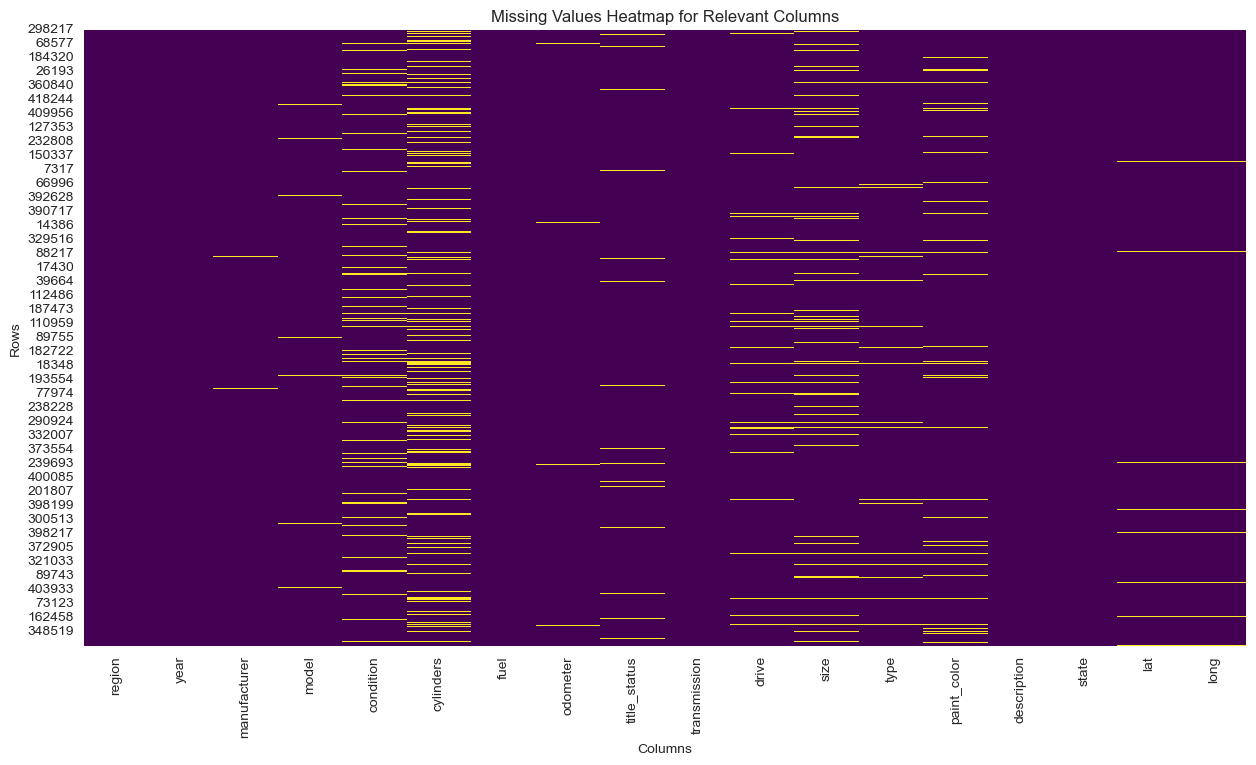

In [40]:
plt.figure(figsize=(15, 8))
sns.heatmap(train_copy.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap for Relevant Columns')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.show()

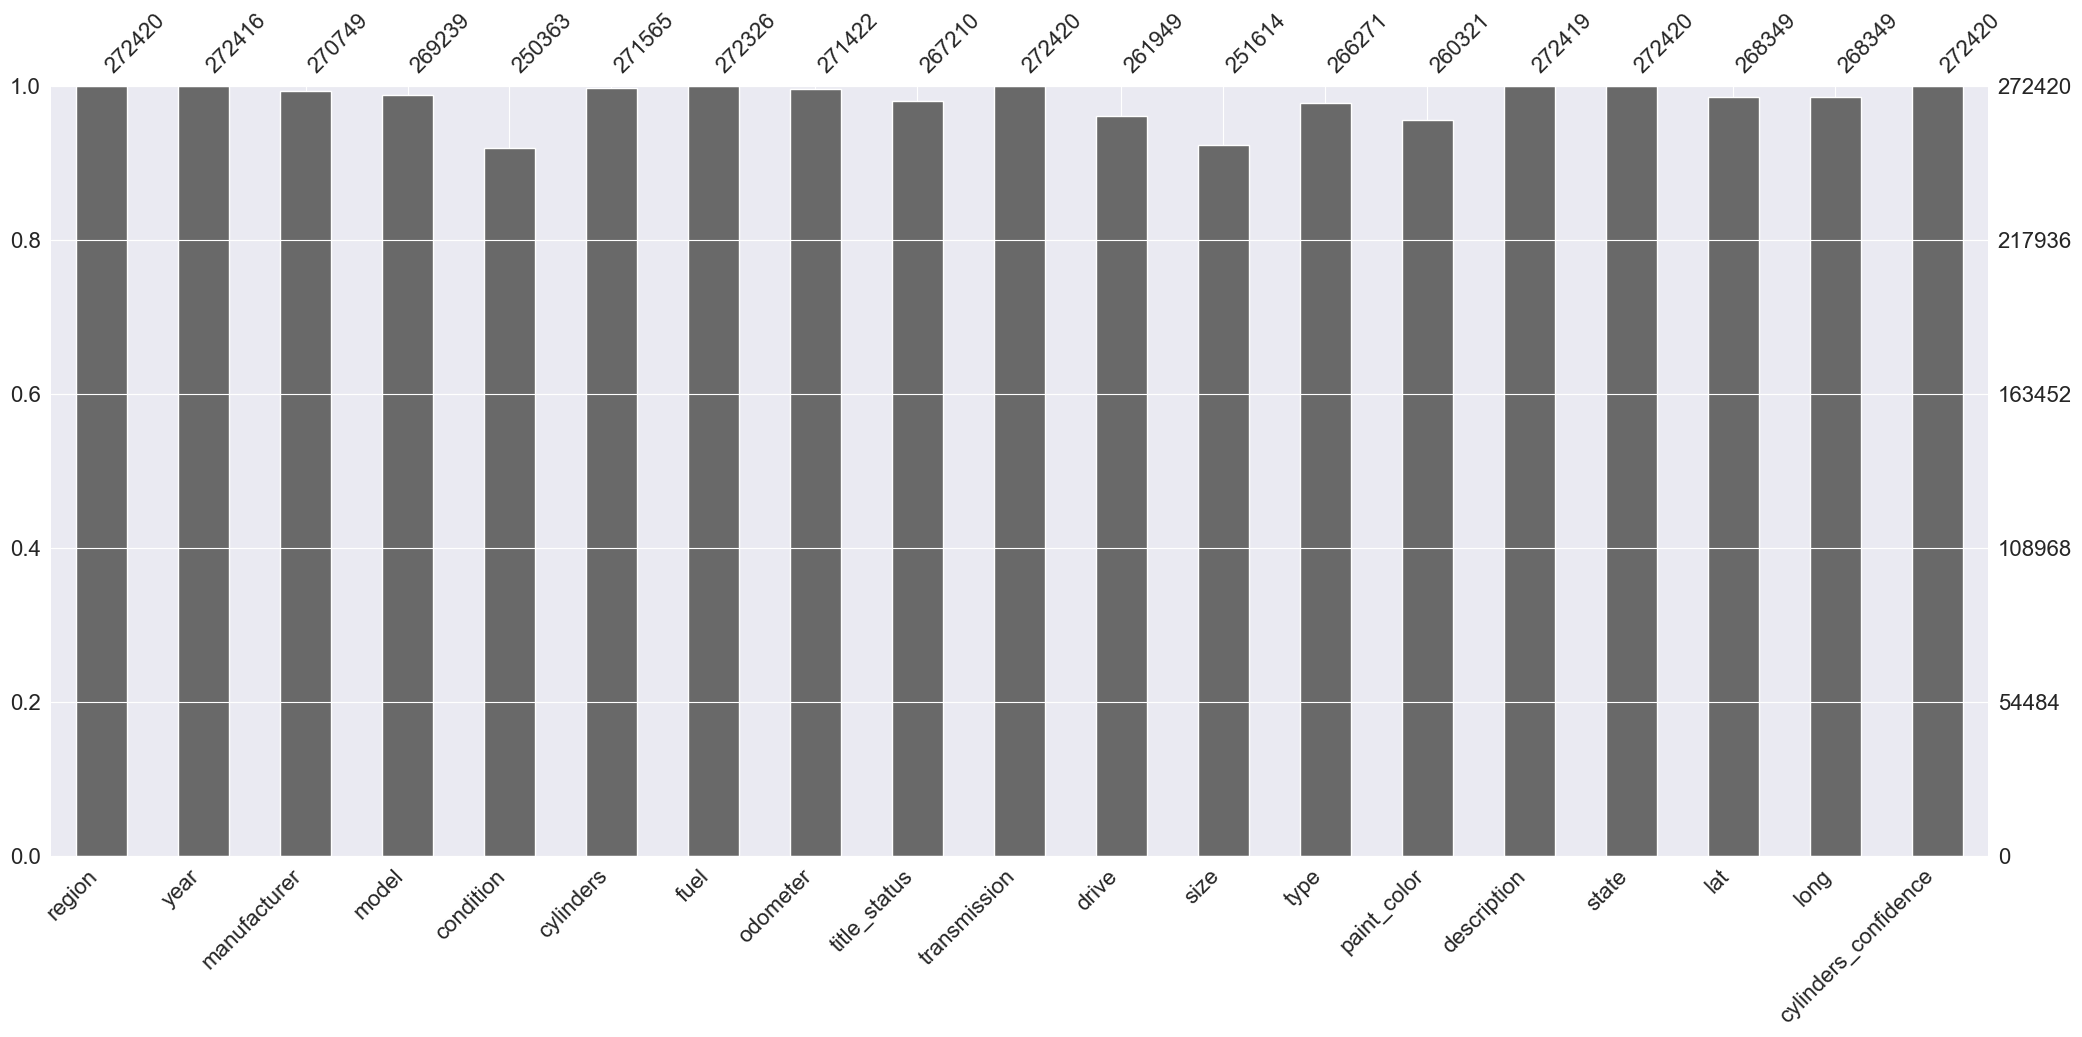

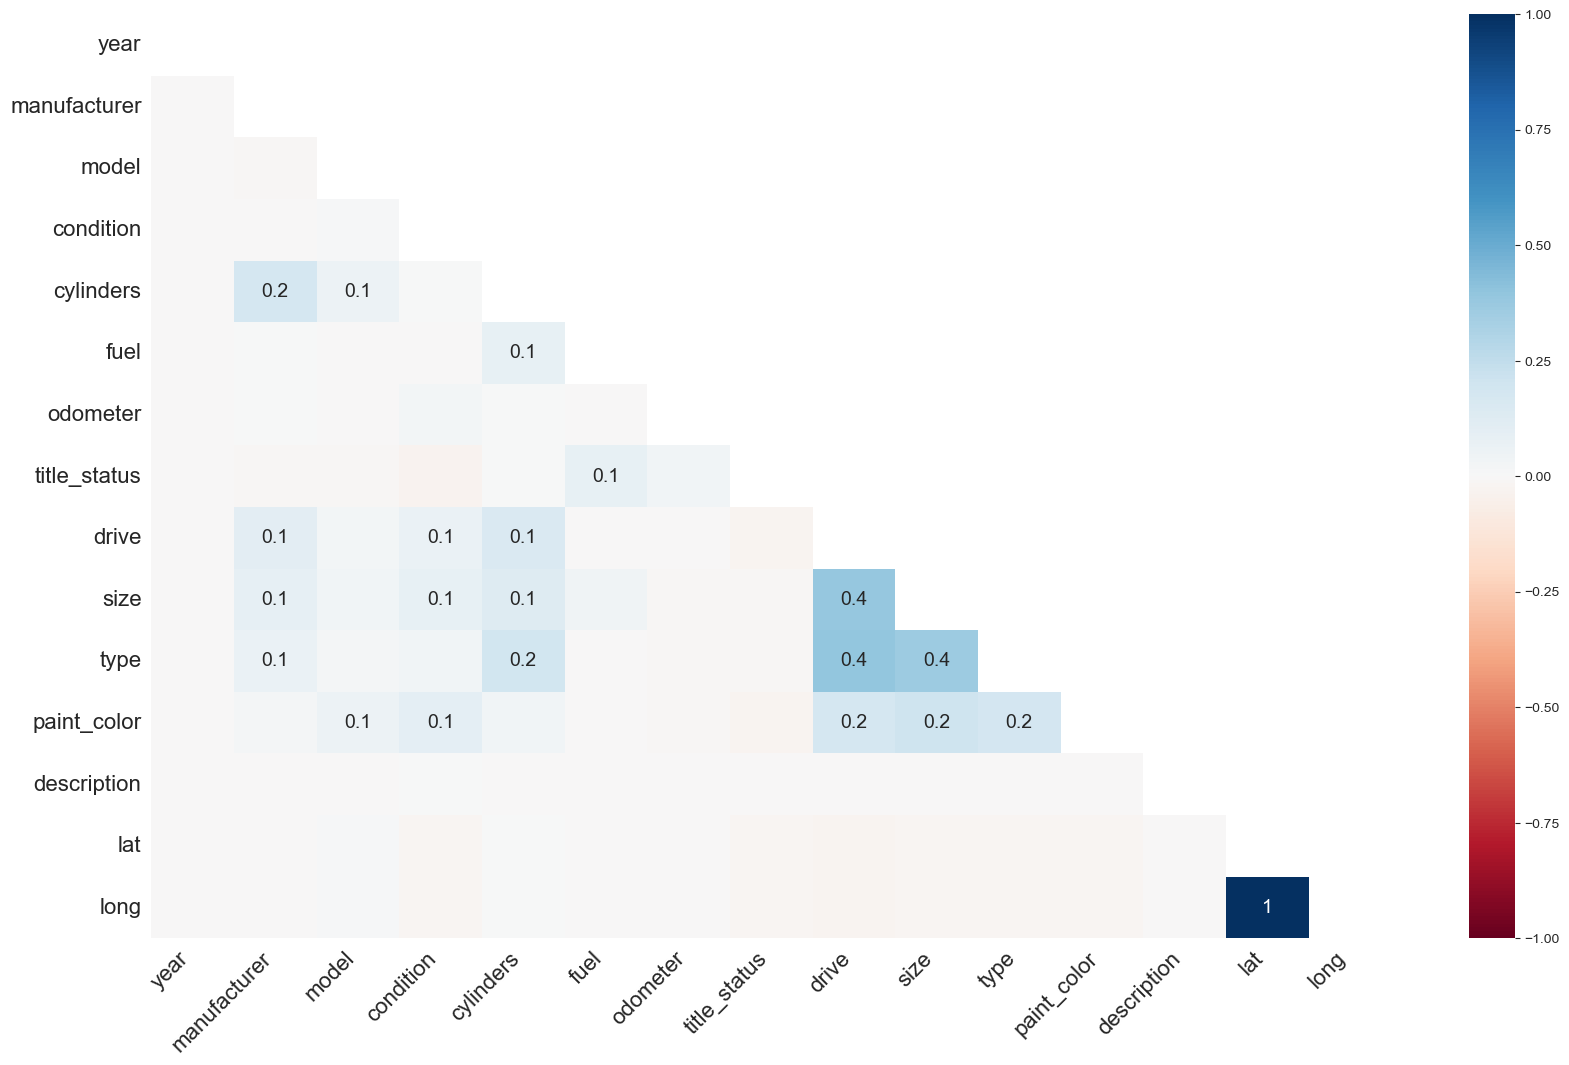

In [64]:
import missingno as msno
msno.bar(train_copy)    # Bar chart of missingness
msno.heatmap(train_copy) # Correlation of missingness
plt.show()

# We'll use a more complex way to make out the remaining null values of cylinders (since it's an important feature, and it still has a high amount of null values)

In [42]:
# Create a priority mapping from non-null entries
engine_map = train_copy.dropna(subset=['cylinders']).groupby(
    ['manufacturer', 'model', 'year']
)['cylinders'].agg(
    lambda x: x.mode()[0] if not x.mode().empty else None
).reset_index()

# Merge with original data
train_copy = train_copy.merge(
    engine_map.rename(columns={'cylinders': 'engine_cylinders'}),
    on=['manufacturer', 'model', 'year'],
    how='left'
)

C:\Users\wissam_T\AppData\Local\Temp\ipykernel_15304\697687931.py:5: UserWarning: Unable to sort modes: '<' not supported between instances of 'int' and 'str'
  lambda x: x.mode()[0] if not x.mode().empty else None
C:\Users\wissam_T\AppData\Local\Temp\ipykernel_15304\697687931.py:5: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  lambda x: x.mode()[0] if not x.mode().empty else None


In [43]:
# Extract engine size from description where available
train_copy['engine_size'] = train_copy['description'].str.extract(r'(\d\.\dL)')[0]

# Map common engine sizes to cylinders
engine_size_map = {
    '1.0L': '3 cylinders', '1.2L': '3 cylinders',
    '1.4L': '4 cylinders', '1.5L': '4 cylinders',
    '1.6L': '4 cylinders', '1.8L': '4 cylinders',
    '2.0L': '4 cylinders', '2.4L': '4 cylinders',
    '2.5L': '4 cylinders', '3.0L': '6 cylinders',
    '3.5L': '6 cylinders', '4.0L': '8 cylinders',
    '5.0L': '8 cylinders', '6.0L': '12 cylinders'
}

train_copy['size_cylinders'] = train_copy['engine_size'].map(engine_size_map)

In [44]:
# Expanded cylinder patterns including engine codes
cylinder_patterns = [
    (r'\b(v\d)\b', lambda m: f"{m.group(1)[1]} cylinders"),  # V6
    (r'\b(i\d)\b', lambda m: f"{m.group(1)[1]} cylinders"),  # I4
    (r'\b(\d)\s*cyl\b', lambda m: f"{m.group(1)} cylinders"),
    (r'\b(\d)\s*pot\b', lambda m: f"{m.group(1)} cylinders"),  # 6-pot
    (r'\b(\d)\s*spd\b', lambda m: f"{m.group(1)} cylinders" if int(m.group(1)) in [4,6,8] else None),
    (r'\b(b\d+)\b', lambda m: f"{m.group(1)[1:]} cylinders"),  # B58 → 8
    (r'\b(n20|n55)\b', lambda m: '4 cylinders' if m.group(1)[1:] == '20' else '6 cylinders'),
    (r'\b(ls\d)\b', lambda m: '8 cylinders'),  # LS engines
    (r'\b(2jz|7m)\b', lambda m: '6 cylinders'),  # Toyota engines
    (r'\b(rb\d+)\b', lambda m: '6 cylinders'),  # Nissan RB series
    (r'\b(13b|20b)\b', lambda m: 'rotary')  # Mazda rotary
]

def extract_cylinders_from_desc(desc):
    if pd.isna(desc):
        return None
    for pattern, converter in cylinder_patterns:
        match = re.search(pattern, desc.lower())
        if match:
            try:
                return converter(match)
            except:
                continue
    return None

train_copy['desc_cylinders'] = train_copy['description'].apply(extract_cylinders_from_desc)

In [45]:
# Map vehicle types to likely cylinder counts
type_cylinder_map = {
    'sedan': '4 cylinders',
    'compact': '4 cylinders',
    'coupe': '6 cylinders',
    'SUV': '6 cylinders',
    'truck': '8 cylinders',
    'van': '6 cylinders',
    'convertible': '6 cylinders',
    'hatchback': '4 cylinders'
}

train_copy['type_cylinders'] = train_copy['type'].map(type_cylinder_map)

In [46]:
# Apply in order of confidence
train_copy['cylinders'] = (
    train_copy['cylinders']
    .fillna(train_copy['engine_cylinders'])  # Most accurate (specific model/year)
    .fillna(train_copy['desc_cylinders'])    # Direct from description
    .fillna(train_copy['size_cylinders'])    # From engine size
    .fillna(train_copy['type_cylinders'])    # Fallback to vehicle type
)

In [47]:
# Check remaining nulls
print(f"Remaining nulls: {train_copy['cylinders'].isna().sum()}")

# Cross-check with known manufacturer defaults
manufacturer_defaults = {
    'toyota': '4 cylinders',
    'ford': '6 cylinders',
    'bmw': '4 cylinders',
    'chevrolet': '8 cylinders'
}

train_copy.loc[train_copy['cylinders'].isna(), 'cylinders'] = train_copy['manufacturer'].map(manufacturer_defaults)

# Add confidence flag
train_copy['cylinders_confidence'] = (
    (~train_copy['engine_cylinders'].isna()).astype(int) * 3 +  # Highest confidence
    (~train_copy['desc_cylinders'].isna()).astype(int) * 2 +
    (~train_copy['size_cylinders'].isna()).astype(int) * 1
)

Remaining nulls: 1181


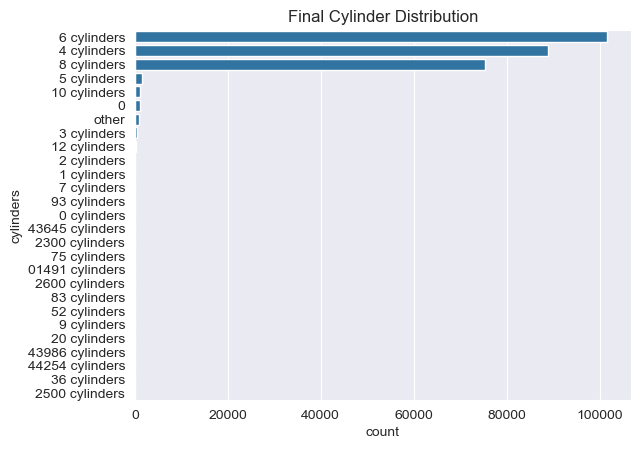

In [48]:
import seaborn as sns
sns.countplot(data=train_copy, y='cylinders', order=train_copy['cylinders'].value_counts().index)
plt.title('Final Cylinder Distribution')
plt.show()

In [49]:
train_copy.drop(['engine_cylinders', 'desc_cylinders', 'size_cylinders', 'desc_cylinders', 'engine_size', 'type_cylinders'], axis=1, inplace=True)

In [50]:
condition_fuel_not_electric = train_copy['fuel'] != 'electric'

# Condition 2: cylinders is 0
condition_cylinders_zero = train_copy['cylinders'] == 0

# Combine conditions using the logical AND operator (&)
filtered_cars = train_copy[condition_fuel_not_electric & condition_cylinders_zero]

filtered_cars

,region,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,description,state,lat,long,cylinders_confidence
941,tyler / east TX,2019.0,tesla,model 3 standard range,good,0,gas,31540.0,clean,other,rwd,mid-size,sedan,white,Carvana is the safer way to buy a car During t...,tx,32.320000,-95.300000,3
10086,salem,2017.0,volkswagen,e-golf,like new,0,gas,23841.0,clean,automatic,fwd,compact,hatchback,black,2017 Volkswagen e-Golf SEL Premium Hatchback S...,or,45.524894,-122.656061,3
13336,skagit / island / SJI,2019.0,hyundai,ioniq,excellent,0,hybrid,53133.0,clean,automatic,unknown,mid-size,hatchback,blue,2019 Hyundai Ioniq Hybrid Limited Offered ...,wa,48.756740,-122.450520,6
13566,pittsburgh,2019.0,nissan,leaf s hatchback 4d,good,0,other,16191.0,clean,other,fwd,mid-size,hatchback,black,Carvana is the safer way to buy a car During t...,pa,40.430000,-79.970000,3
13925,memphis,2018.0,mitsubishi,outlander phev gt,good,0,other,36773.0,clean,other,4wd,mid-size,other,black,Carvana is the safer way to buy a car During t...,tn,35.100000,-90.000000,3
20352,san marcos,2019.0,tesla,model 3 standard range,good,0,gas,31540.0,clean,other,rwd,mid-size,sedan,white,Carvana is the safer way to buy a car During t...,tx,29.880000,-97.920000,3
22900,south bend / michiana,2017.0,fiat,500e,None,0,gas,15388.0,clean,automatic,fwd,None,sedan,white,RightWay Elkhart address: 1201 N Nappanee S...,in,41.699069,-86.005181,3
27674,dallas / fort worth,2019.0,nissan,leaf sv hatchback 4d,good,0,other,5381.0,clean,other,fwd,mid-size,hatchback,blue,Carvana is the safer way to buy a car During t...,tx,32.850000,-96.960000,3
32351,cincinnati,2018.0,tesla,model x 75d sport utility,good,0,gas,15003.0,clean,other,awd,mid-size,SUV,silver,Carvana is the safer way to buy a car During t...,oh,39.090000,-84.510000,3
32856,monterey bay,2017.0,ford,focus electric hatchback 4d,good,0,gas,19510.0,clean,other,fwd,mid-size,hatchback,white,Carvana is the safer way to buy a car During t...,ca,36.600000,-121.880000,3


In [261]:
def identify_electric_vehicles(df):
    # Known 100% EV manufacturers (lowercase for case-insensitive matching)
    ev_makes = {
        'tesla', 'rivian', 'lucid', 'fisker', 'polestar', 
        'nio', 'xpeng', 'li auto', 'byton', 'faraday future'
    }
    
    # Model patterns indicating EVs
    ev_model_patterns = [
    r'\be-?\d',                # e-tron, e6, e-golf
    r'\bvolt\b',               # Chevy Volt
    r'\bbolt\b',               # Chevy Bolt
    r'\bleaf\b',               # Nissan Leaf
    r'\bion(?:iq)?\b',         # Hyundai Ioniq/Ioniq5
    r'\bev\b',                 # Model EV
    r'\belectr',               # Electric, Electra
    r'\bphev\b',               # Plug-in Hybrid
    r'\bzoe\b',                # Renault Zoe
    r'\bmodel [s3xy]',         # Tesla Models
    r'\bid\b',                 # VW ID.4
    r'\b(?:\d+)i\b',           # BMW i3, i8
    r'\bmirai\b',              # Toyota Mirai
    r'\bmustang mach-e\b',     # Ford Mustang Mach-E
    ]
    
    # Description keywords
    ev_desc_keywords = [
        'electric vehicle', 'zero emission', 'battery powered',
        'ev range', 'kwh battery', 'plug in', 'charger included',
        'supercharger', 'wall connector'
    ]
    
    # Create boolean masks (with NA handling)
    make_mask = df['manufacturer'].str.lower().fillna('').isin(ev_makes)
    
    model_mask = (
        df['model']
        .str.lower()
        .fillna('')
        .str.contains('|'.join(ev_model_patterns), regex=True, na=False)
    )
    
    desc_mask = (
        df['description']
        .str.lower()
        .fillna('')
        .str.contains('|'.join(ev_desc_keywords), regex=True, na=False)
    )
    
    # Combine conditions
    is_ev = make_mask | model_mask | desc_mask
    
    # Special case handling (override false positives)
    hybrid_exceptions = ['prius prime', 'rav4 prime']
    hybrid_mask = (
        df['model']
        .str.lower()
        .fillna('')
        .isin(hybrid_exceptions)
    )
    is_ev = is_ev & ~hybrid_mask
    
    return is_ev

# Apply the filter
train_copy['fuel'] = np.where(identify_electric_vehicles(train_copy), 'electric', train_copy['fuel'])

In [52]:
condition_fuel_not_electric = train_copy['fuel'] != 'electric'

# Condition 2: cylinders is 0
condition_cylinders_zero = train_copy['cylinders'] == 0

# Combine conditions using the logical AND operator (&)
filtered_cars = train_copy[condition_fuel_not_electric & condition_cylinders_zero]

filtered_cars

,region,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,description,state,lat,long,cylinders_confidence
10086,salem,2017.0,volkswagen,e-golf,like new,0,gas,23841.0,clean,automatic,fwd,compact,hatchback,black,2017 Volkswagen e-Golf SEL Premium Hatchback S...,or,45.524894,-122.656061,3
22900,south bend / michiana,2017.0,fiat,500e,None,0,gas,15388.0,clean,automatic,fwd,None,sedan,white,RightWay Elkhart address: 1201 N Nappanee S...,in,41.699069,-86.005181,3
54446,seattle-tacoma,2014.0,bmw,i3,new,0,other,41588.0,clean,automatic,rwd,sub-compact,hatchback,custom,Most common questions about this vehicle: Wan...,wa,47.614533,-122.168798,5
67090,el paso,2014.0,bmw,i3 hatchback 4d,good,0,other,28799.0,clean,other,rwd,mid-size,hatchback,white,Carvana is the safer way to buy a car During t...,tx,31.840000,-106.430000,5
139085,dallas / fort worth,2018.0,audi,a3 premium plus sedan 4d,good,0,gas,12664.0,clean,other,awd,mid-size,sedan,blue,Carvana is the safer way to buy a car During t...,tx,32.750000,-97.330000,6
157527,new york city,2016.0,volkswagen,e-golf se hatchback,good,0,other,15638.0,clean,other,fwd,mid-size,sedan,blue,Carvana is the safer way to buy a car During t...,ny,40.720000,-74.170000,3
184735,atlanta,2018.0,audi,a3 premium plus sedan 4d,good,0,gas,12664.0,clean,other,awd,mid-size,sedan,blue,Carvana is the safer way to buy a car During t...,ga,33.710000,-84.530000,6
219302,salem,2018.0,bmw,i3,new,0,gas,15173.0,clean,automatic,rwd,large,sedan,black,Volkswagen of Salem STOCK #: NB86854 F...,or,44.973187,-123.018138,5
253727,portland,2019.0,nissan,versa sv sedan 4d,good,0,gas,2933.0,clean,other,fwd,mid-size,sedan,white,Carvana is the safer way to buy a car During t...,or,33.779214,-84.411811,6


In [69]:
null_with_percentage(train_copy)

Null Value Counts and Percentages per Column:
                      Null Count  Null Percentage
condition                  22057         8.096689
size                       20806         7.637472
paint_color                12099         4.441304
drive                      10471         3.843697
type                        6149         2.257176
title_status                5210         1.912488
lat                         4071         1.494384
long                        4071         1.494384
model                       3181         1.167682
manufacturer                1671         0.613391
odometer                     998         0.366346
cylinders                    855         0.313854
fuel                          94         0.034506
year                           4         0.001468
description                    1         0.000367
region                         0         0.000000
transmission                   0         0.000000
state                          0         0.000000
cyli

# We want to use the odometer to estimate the car's condition, first we will fix the out-layer values we noticed in the data analysis section

In [76]:
min_mileage = train_copy['odometer'].min()
max_mileage = train_copy['odometer'].max()

print(f"Minimum mileage value: {min_mileage}")
print(f"Maximum mileage value: {max_mileage}")
print(f"Range of mileage values: {min_mileage} to {max_mileage}")

Minimum mileage value: 0.0
Maximum mileage value: 10000000.0
Range of mileage values: 0.0 to 10000000.0


In [81]:
max_odometer_value = train_copy[train_copy['odometer'] == max_mileage ]

max_odometer_value

,region,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,description,state,lat,long,cylinders_confidence
3767,minneapolis / st paul,2021.0,bmw,NaN,None,6 cylinders,other,10000000.0,clean,other,4wd,full-size,SUV,None,SM auto repair and performance We can do it a...,mn,44.991200,-93.581800,0
4975,ventura county,2007.0,toyota,NaN,good,4 cylinders,gas,10000000.0,clean,automatic,4wd,mid-size,SUV,None,2007 Toyota Tundra V/8 automatic 4.7 4door R...,ca,34.330800,-119.358400,0
11920,sarasota-bradenton,2000.0,ford,f-150,fair,6 cylinders,gas,10000000.0,clean,automatic,fwd,full-size,mini-van,black,FLATBED TOW TRUCKS AVAILABLE 24/7 @ YOUR REQUE...,fl,27.368800,-82.526800,3
12375,oklahoma city,1995.0,chevrolet,impala ss 1995,fair,8 cylinders,gas,10000000.0,clean,automatic,rwd,full-size,sedan,custom,SS Impala 1995 REAL SS clear title body in gr...,ok,35.796482,-97.674127,3
15825,indianapolis,1949.0,ford,model a,good,4 cylinders,gas,10000000.0,clean,manual,rwd,mid-size,sedan,black,1949 ford f3 truck cab.no title Model t mode...,in,39.362800,-86.280300,3
34614,sarasota-bradenton,2000.0,ford,f-150,fair,6 cylinders,gas,10000000.0,clean,automatic,4wd,mid-size,sedan,black,FLATBED TOW TRUCKS AVAILABLE 24/7 @ YOUR REQUE...,fl,27.368800,-82.526800,3
47104,sarasota-bradenton,2000.0,ford,f-150,fair,8 cylinders,gas,10000000.0,clean,automatic,4wd,full-size,pickup,black,FLATBED TOW TRUCKS AVAILABLE 24/7 @ YOUR REQUE...,fl,27.368800,-82.526800,3
48753,sarasota-bradenton,1984.0,mazda,NaN,None,8 cylinders,gas,10000000.0,clean,automatic,4wd,full-size,truck,None,Mazda rx7 title roll cage posi gsl model nine ...,fl,27.484100,-82.583400,0
59664,albuquerque,1973.0,jeep,cj5,good,8 cylinders,gas,10000000.0,clean,manual,4wd,None,offroad,black,Great old Mad Max vehicle. Strong 304. 3 spe...,nm,35.150898,-106.615356,3
81721,gold country,1951.0,chevrolet,coe,good,8 cylinders,gas,10000000.0,clean,automatic,rwd,full-size,truck,custom,1951 CHEVY COE. FUEL INJECTED 350 TUBRO 400 AU...,ca,37.956759,-120.311279,3


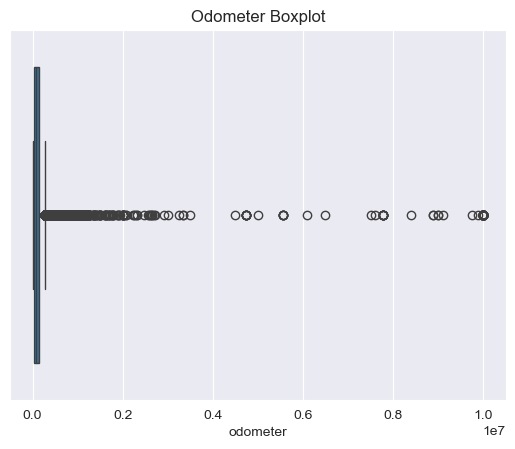

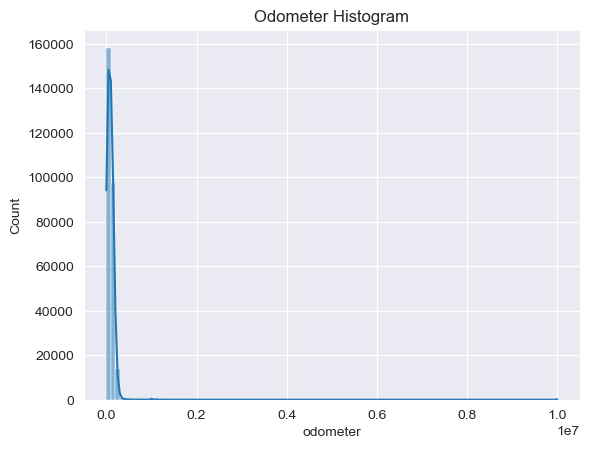

In [113]:
sns.boxplot(x=train_copy['odometer'])
plt.title("Odometer Boxplot")
plt.show()

sns.histplot(train_copy['odometer'], bins=100, kde=True)
plt.title("Odometer Histogram")
plt.show()


In [128]:
# Consider cars with less than 1,000 or more than 300,000 miles as outliers
LOWER_BOUND = 1000
UPPER_BOUND = 600000

Q1 = train_copy['odometer'].quantile(0.25)
Q3 = train_copy['odometer'].quantile(0.75)
IQR = Q3 - Q1
lower_fence = Q1 - 1.5 * IQR
upper_fence = Q3 + 1.5 * IQR


outlier_mask = (train_copy['odometer'] < LOWER_BOUND) | (train_copy['odometer'] > UPPER_BOUND)
outlier_count = outlier_mask.sum()
print(f"Outliers detected: {outlier_count}")

Outliers detected: 8881


In [129]:
train_copy['odometer_outlier'] = outlier_mask.astype(int)

In [130]:
train_copy.head()

,region,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,...,size,type,paint_color,description,state,lat,long,cylinders_confidence,mileage_condition,odometer_outlier
0,dayton / springfield,2007.0,honda,crv ex,fair,4 cylinders,gas,222156.0,clean,automatic,...,None,None,None,All wheel drive well maintained,oh,39.6062,-84.1695,3,salvage,0
1,sarasota-bradenton,2005.0,ford,-,salvage,8 cylinders,gas,1.0,clean,automatic,...,full-size,truck,gray,"Any year, make, model, and in any condition. W...",fl,27.0933,-82.4498,3,new,1
2,visalia-tulare,2003.0,jeep,wrangler rubicon,excellent,6 cylinders,gas,24216.0,clean,automatic,...,mid-size,SUV,red,"Jeep Rubicon---24,216 miles. Probably like you...",ca,36.0686,-119.0315,3,like new,0
3,topeka,2019.0,honda,civic si sedan 4d,good,6 cylinders,gas,40319.0,clean,other,...,compact,sedan,blue,Carvana is the safer way to buy a car During t...,ks,39.0300,-95.6900,6,like new,0
4,yuma,2007.0,toyota,fj cruiser,good,6 cylinders,gas,188175.0,rebuilt,automatic,...,mid-size,other,silver,Toyota fj 2007 new km2 tires cold a/c 4x4 led ...,az,32.4870,-114.7822,3,fair,0


# Since condition still has a high percentage null value, we'll use the milage to estimate the car condition  

In [133]:
train['condition'].value_counts()

condition
good         77802
excellent    64819
like new     13563
fair          4324
new            826
salvage        373
Name: count, dtype: int64

In [134]:
def estimate_condition_by_mileage(df):
    # Define all possible condition categories
    all_conditions = ['new', 'like new', 'excellent', 'good', 'fair', 'salvage', 'commercial']
    
    # Create mileage bins
    bins = [0, 20000, 50000, 100000, 150000, 200000, float('inf')]
    labels = ['new', 'like new', 'excellent', 'good', 'fair', 'salvage']
    
    # Ensure odometer is numeric
    df['odometer'] = pd.to_numeric(df['odometer'], errors='coerce')
    
    # Create temporary mileage condition column
    df['mileage_condition'] = pd.cut(
        df['odometer'],
        bins=bins,
        labels=labels,
        right=False
    ).astype('object')  # Convert to object first to avoid categorical issues
    
    # Adjust for vehicle age
    df.loc[(df['year'] >= 2020) & (df['odometer'] <= 50000), 'mileage_condition'] = 'like new'
    
    # Handle commercial vehicles
    commercial_types = ['truck', 'van', 'commercial']
    df.loc[df['type'].isin(commercial_types), 'mileage_condition'] = 'commercial'
    
    # Convert to categorical with all possible categories
    df['mileage_condition'] = pd.Categorical(
        df['mileage_condition'],
        categories=all_conditions,
        ordered=True
    )
    
    return df

train_copy = estimate_condition_by_mileage(train_copy)

In [135]:
def fill_condition_with_context(df):
    # Ensure condition column is categorical with all possible categories
    all_conditions = ['new', 'like new', 'excellent', 'good', 'fair', 'salvage', 'commercial']
    df['condition'] = pd.Categorical(
        df['condition'],
        categories=all_conditions,
        ordered=True
    )
    
    # Priority 1: Use existing condition if available
    df['condition'] = df['condition'].fillna(pd.NA)
    
    # Priority 2: Use mileage-based estimate for normal passenger vehicles
    passenger_mask = (~df['type'].isin(['truck', 'van', 'commercial'])) & df['odometer'].notna()
    df.loc[passenger_mask, 'condition'] = df.loc[passenger_mask, 'condition'].fillna(
        df.loc[passenger_mask, 'mileage_condition'].astype('object')  # Convert to object for filling
    )
    
    # Priority 3: For commercial vehicles
    commercial_mask = df['type'].isin(['truck', 'van', 'commercial']) & df['odometer'].notna()
    df.loc[commercial_mask, 'condition'] = df.loc[commercial_mask, 'condition'].fillna(
        'commercial'  # Directly use the string instead of concatenation
    )
    
    # Priority 4: Manufacturer averages
    manufacturer_condition = df.groupby('manufacturer')['condition'].apply(
        lambda x: x.mode()[0] if not x.mode().empty else 'good'
    )
    df['condition'] = df['condition'].fillna(
        df['manufacturer'].map(manufacturer_condition).astype('object')
    )
    
    # Priority 5: Final fallback
    df['condition'] = df['condition'].fillna('good')
    
    # Ensure final type is categorical
    df['condition'] = pd.Categorical(
        df['condition'],
        categories=all_conditions,
        ordered=True
    )
    
    return df

train_copy = fill_condition_with_context(train_copy)

In [136]:
def validate_condition_fills(df):
    # Add confidence score (1-5)
    df['condition_confidence'] = 5  # Highest for original values
    df.loc[df['condition'].isna(), 'condition_confidence'] = 0
    
    # Mileage-based fills get confidence 4
    mileage_filled = df['condition'].notna() & df['mileage_condition'].notna()
    df.loc[mileage_filled, 'condition_confidence'] = 4
    
    # Commercial adjustments get confidence 3
    df.loc[df['condition'].str.contains('commercial use', na=False), 'condition_confidence'] = 3
    
    # Manufacturer averages get confidence 2
    manu_filled = df['condition'].notna() & (df['condition_confidence'] < 3)
    df.loc[manu_filled, 'condition_confidence'] = 2
    
    # Final fallback gets confidence 1
    df.loc[df['condition'] == 'good', 'condition_confidence'] = 1
    
    # Spot check extremes
    high_mileage_new = df[(df['odometer'] > 100000) & (df['condition'] == 'new')]
    if not high_mileage_new.empty:
        print(f"Warning: {len(high_mileage_new)} high-mileage 'new' vehicles found")
    
    return df

train_copy = validate_condition_fills(train_copy)

In [137]:
# Clean up temporary columns
train_copy.drop(columns=['mileage_condition'], inplace=True)

# Export with confidence scores
train_copy.to_csv('vehicles_with_condition_filled.csv', index=False)

print(f"Filled {train_copy['condition'].isna().sum()} remaining nulls")
print("Condition distribution:")
print(train_copy['condition'].value_counts(normalize=True))

Filled 0 remaining nulls
Condition distribution:
condition
good          0.400279
excellent     0.317231
like new      0.119228
new           0.079440
fair          0.040592
commercial    0.028566
salvage       0.014665
Name: proportion, dtype: float64


In [140]:
train_copy['condition_confidence']

0         4
1         4
2         4
3         1
4         1
         ..
272415    5
272416    4
272417    4
272418    4
272419    4
Name: condition_confidence, Length: 272420, dtype: int64

In [143]:
null_with_percentage(train_copy)

Null Value Counts and Percentages per Column:
                      Null Count  Null Percentage
size                       20806         7.637472
paint_color                12099         4.441304
drive                      10471         3.843697
type                        6149         2.257176
title_status                5210         1.912488
lat                         4071         1.494384
long                        4071         1.494384
model                       3181         1.167682
manufacturer                1671         0.613391
odometer                     998         0.366346
cylinders                    855         0.313854
fuel                          94         0.034506
year                           4         0.001468
description                    1         0.000367
odometer_outlier               0         0.000000
cylinders_confidence           0         0.000000
region                         0         0.000000
state                          0         0.000000
tran

# We'll turn all electric car's cylinder info to 0, and clean up the cylinder category

In [149]:
og = train_copy[train_copy['cylinders'] == 'other']

og

,region,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,...,size,type,paint_color,description,state,lat,long,cylinders_confidence,odometer_outlier,condition_confidence
926,cincinnati,2013.0,None,"Hustler Super Z 60"" Zero Turn Lawn Mower",new,other,gas,0.0,clean,automatic,...,None,other,None,"2013 Hustler Super Z 60"" Zero Turn Lawn MowerV...",oh,39.073100,-84.325896,0,1,4
962,inland empire,1900.0,lexus,All,fair,other,other,100000.0,clean,other,...,compact,other,custom,1. information of What you are trying to sell ...,ca,33.879700,-117.535400,3,0,4
1053,olympic peninsula,2020.0,ford,escape,good,other,gas,16399.0,clean,automatic,...,subcompact,SUV,custom,Joydrive: 253-201-0804 https://joydrive.com/...,wa,47.199100,-122.315100,4,0,1
1066,chico,2006.0,chevrolet,express g1500,good,other,gas,122403.0,clean,automatic,...,full-size,van,white,2006 Chevrolet Express G1500 Van2006 CHEVROLET...,ca,37.797142,-121.230484,3,0,1
1303,baltimore,2016.0,tesla,NEW MODELS,excellent,other,electric,70000.0,clean,automatic,...,None,sedan,red,"FIRST TIME BUYERS, REPOES, BANKRUPTCYS.....ALL...",md,39.363925,-76.791000,3,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269508,baton rouge,2018.0,toyota,NaN,like new,other,other,8000.0,clean,other,...,None,coupe,red,LOOKING FOR ECONOMY RELIABILITY AND VALUE?????...,la,29.893277,-90.122962,0,0,4
269607,redding,2001.0,honda,civic,fair,other,gas,232664.0,clean,automatic,...,compact,sedan,blue,2001 Honda Civic EX 4-door automatic Sedan. C...,ca,40.560500,-122.411600,3,0,4
271068,south florida,2013.0,rover,2013,excellent,other,gas,121166.0,NaN,automatic,...,full-size,SUV,white,2013 Land Rover Range Rover 2013 Land Rover Ra...,fl,25.992692,-80.142182,6,0,4
271725,raleigh / durham / CH,2000.0,hyundai,all,fair,other,gas,200000.0,clean,other,...,full-size,sedan,custom,Buying junk cars in wake county and surroundin...,nc,35.673100,-78.801500,3,0,4


In [158]:
def clean_ev_cylinders(df):
    # Convert cylinders to string type if mixed types exist
    if df['cylinders'].dtype == 'object':
        df['cylinders'] = df['cylinders'].astype(str)
    
    # Standard EV identifiers
    ev_indicators = {
        'fuel': ['electric'],
        'manufacturer': ['tesla', 'rivian', 'lucid', 'polestar', 'nio'],
        'model': ['model s', 'model 3', 'model x', 'model y', 'ev6', 'ioniq'],
        'description': ['zero emission', 'battery electric', 'kwh battery']
    }
    
    # Create comprehensive EV mask
    ev_mask = (
        df['fuel'].str.lower().isin(ev_indicators['fuel']) |
        df['manufacturer'].str.lower().isin(ev_indicators['manufacturer']) |
        df['model'].str.lower().str.contains('|'.join(ev_indicators['model']), na=False) |
        df['description'].str.lower().str.contains('|'.join(ev_indicators['description']), na=False)
    )
    
    # Clean cylinder values
    df.loc[ev_mask, 'cylinders'] = 'electric'
    
    # Find and report any combustion engine terms in EVs
    combustion_terms = r'\b(v\d|i\d|\d[\s-]?cyl|\d[\s-]?liter|l\d)\b'
    evs_with_engine_terms = df[ev_mask & 
                             df['description'].str.contains(combustion_terms, case=False, na=False)]
    
    if not evs_with_engine_terms.empty:
        print(f"Found {len(evs_with_engine_terms)} EVs with engine terms:")
        print(evs_with_engine_terms[['manufacturer', 'model', 'cylinders', 'description']].head())
    
    return df

# Apply the cleaning
train_copy = clean_ev_cylinders(train_copy)

C:\Users\wissam_T\AppData\Local\Temp\ipykernel_15304\2210208345.py:28: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['description'].str.contains(combustion_terms, case=False, na=False)]


Found 5195 EVs with engine terms:
    manufacturer                   model cylinders  \
44          ford                focus se  electric   
94          ford              e250 cargo  electric   
100          bmw                    430i  electric   
101          bmw  2 series 228i coupe 2d  electric   
166          bmw  3 series 340i sedan 4d  electric   

                                           description  
44   2004 Ford Focus SE162,185 mi. - Automatic - 4D...  
94   If you're looking for that hard to find Cargo ...  
100  ONLY 8,000 MILES 2018 BMW 430i Convertible is ...  
101  Carvana is the safer way to buy a car During t...  
166  Carvana is the safer way to buy a car During t...  


In [161]:
temp = train_copy[(train_copy['fuel'] == 'electric') & (train_copy['cylinders'] == 'electric') ]

temp

,region,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,...,size,type,paint_color,description,state,lat,long,cylinders_confidence,odometer_outlier,condition_confidence
15,little rock,2014.0,ford,e250 cargo van,like new,electric,electric,168799.0,clean,automatic,...,mid-size,SUV,white,"POWER LIFT, AUTOMATIC, POWER WINDOWS-LOCKS-MIR...",ar,34.867736,-92.196836,3,0,4
44,yuba-sutter,2004.0,ford,focus se,excellent,electric,electric,162185.0,clean,automatic,...,full-size,sedan,white,"2004 Ford Focus SE162,185 mi. - Automatic - 4D...",ca,39.123441,-121.611440,6,0,4
94,daytona beach,2007.0,ford,e250 cargo,excellent,electric,electric,122703.0,clean,automatic,...,full-size,van,white,If you're looking for that hard to find Cargo ...,fl,29.026600,-81.334900,5,0,4
100,palm springs,2018.0,bmw,430i,excellent,electric,electric,8000.0,clean,automatic,...,extra-large,convertible,gray,"ONLY 8,000 MILES 2018 BMW 430i Convertible is ...",ca,33.743904,-116.359028,6,0,4
101,galveston,2014.0,bmw,2 series 228i coupe 2d,good,electric,electric,49370.0,clean,other,...,mid-size,coupe,black,Carvana is the safer way to buy a car During t...,tx,29.300000,-94.790000,6,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272319,ocala,2012.0,bmw,550i,good,electric,electric,95129.0,clean,automatic,...,full-size,sedan,white,2012 BMW 5-Series 550i Offered by: Auto Ma...,fl,29.164147,-82.134622,5,0,1
272333,little rock,2009.0,ford,e250 cargo van,excellent,electric,electric,122906.0,clean,automatic,...,None,other,white,"""WORK READY"" , 1-OWNER, AUTOMATIC, TOW PACKAG...",ar,34.867310,-92.197275,3,0,4
272345,wyoming,2007.0,ford,e-250,excellent,electric,electric,191863.0,clean,automatic,...,subcompact,van,white,2007 Ford Econoline Cargo Van E-250 Recreation...,wy,40.374375,-104.694103,5,0,4
272369,baltimore,2003.0,bmw,x5 3.0i,fair,electric,electric,191030.0,clean,automatic,...,subcompact,SUV,white,This 2003 BMW X5 3.0i has been SOLD but call o...,md,39.433086,-76.343119,6,0,4


In [165]:
# Filter rows where cylinders is 'other' or None
mask = train_copy['cylinders'].isin(['other', 'None', np.nan])
other_cyl_df = train_copy[mask]
print(f"Rows to analyze: {len(other_cyl_df)}")

Rows to analyze: 1534


In [168]:
# Check if electric vehicles are misclassified
electric_mentions = other_cyl_df['description'].str.lower().str.contains(r'\belectric\b|\bev\b|tesla', na=False)
print(f"Mentions of electric: {electric_mentions.sum()}")

# Check for other cylinder-related mentions
engine_clues = other_cyl_df['description'].str.lower().str.extract(r'(\d)[-\s]?(?:cyl|cylinder|cylinders)')
print(engine_clues[0].value_counts())

Mentions of electric: 158
0
4    91
6    41
8    20
1    14
5     7
2     5
3     4
0     1
7     1
Name: count, dtype: int64


In [167]:
grouped = other_cyl_df.groupby(['manufacturer', 'model']).size().sort_values(ascending=False)
print(grouped.head(10))

manufacturer  model                         
ram           smart fortwo Passion Hatchback    42
              2500                              31
              3500                              19
mazda         rx8                               17
audi          BLUE BIRD BLUE BIRD               16
ford          escape                            16
subaru        wrx                               11
ford          f550                              11
ram           1500                              10
ford          f-150                              9
dtype: int64


In [169]:
print(other_cyl_df['fuel'].value_counts())
print(other_cyl_df['size'].value_counts())

fuel
gas       1046
diesel     232
other      221
hybrid      12
Name: count, dtype: int64
size
full-size      284
compact        247
mid-size       184
subcompact     129
large           51
extra-large     35
sub-compact     25
full            22
Name: count, dtype: int64


In [170]:
def reclassify_other_cylinders(row):
    desc = str(row['description']).lower()
    if 'electric' in desc or 'ev' in desc or row['fuel'] == 'electric':
        return 'electric'
    match = re.search(r'\b(\d)[\s-]?(?:cyl|cylinder)', desc)
    if match:
        return f"{match.group(1)} cylinders"
    return 'unknown'  # fallback if still uncertain

# Apply to 'other' or null cylinders
mask = train_copy['cylinders'].isin(['other', None, np.nan])
train_copy.loc[mask, 'cylinders'] = train_copy.loc[mask].apply(reclassify_other_cylinders, axis=1)

In [172]:
def standardize_cylinders(value):
    if pd.isna(value):
        return 'unknown'
    val = str(value).lower().strip()
    
    # Merge both electric labels
    if val in ['electric', '0 (electric)']:
        return 'electric'
    
    # Merge None and unknown (after all attempts to extract info are exhausted)
    if val in ['none', 'unknown', 'nan']:
        return 'unknown'
    
    return val  # Keep all other values as-is

# Apply function
train_copy['cylinders'] = train_copy['cylinders'].apply(standardize_cylinders)

In [174]:
train_copy['cylinders'].value_counts()

cylinders
6 cylinders        97521
4 cylinders        85163
8 cylinders        72389
electric           12900
5 cylinders         1452
10 cylinders        1079
unknown              844
3 cylinders          571
0 cylinders          246
12 cylinders         219
0                      9
1 cylinders            5
93 cylinders           4
2300 cylinders         3
7 cylinders            3
75 cylinders           2
2600 cylinders         1
01491 cylinders        1
83 cylinders           1
52 cylinders           1
9 cylinders            1
20 cylinders           1
43986 cylinders        1
44254 cylinders        1
36 cylinders           1
2500 cylinders         1
Name: count, dtype: int64

# Finally we'll turn the column numerical as its better for training

In [175]:
def convert_cylinders_to_numeric(value):
    if pd.isna(value):
        return np.nan
    val = str(value).lower().strip()

    if val == 'electric':
        return 0
    if val == 'unknown':
        return np.nan

    match = re.match(r'(\d+)\s*cylinders?', val)
    if match:
        return int(match.group(1))
    
    return np.nan

In [180]:
train_copy['cylinders_numeric'] = train_copy['cylinders'].apply(convert_cylinders_to_numeric)

train_copy.drop(columns=['cylinders'], inplace=True)

In [193]:
train_copy['cylinders_numeric'].value_counts()

cylinders_numeric
6.0        97521
4.0        85163
8.0        72389
0.0         2069
5.0         1452
10.0        1079
3.0          571
12.0         219
1.0            5
93.0           4
7.0            3
2300.0         3
75.0           2
36.0           1
20.0           1
44254.0        1
43986.0        1
2600.0         1
9.0            1
52.0           1
1491.0         1
83.0           1
2500.0         1
Name: count, dtype: int64

# We'll also turn the electric cars to a standalone category by using a flag column that goes 1 if its electric or 0 if its not

In [184]:
train_copy.loc[train_copy['fuel'] == 'electric', 'cylinders_numeric'] = np.nan

In [194]:
train_copy['is_electric'] = (train_copy['fuel'] == 'electric').astype(int)

In [207]:
train_copy[(train_copy['fuel'] == 'other')]

,region,year,manufacturer,model,condition,fuel,odometer,title_status,transmission,drive,...,paint_color,description,state,lat,long,cylinders_confidence,odometer_outlier,condition_confidence,cylinders_numeric,is_electric
40,minneapolis / st paul,2017.0,dodge,grand caravan gt,commercial,other,89963.0,clean,automatic,fwd,...,black,2017 Dodge Grand Caravan GT VanExterior Color:...,mn,44.065620,-93.217461,5,0,4,6.0,0
63,daytona beach,2013.0,ford,f150 super cab,good,other,109326.0,clean,automatic,fwd,...,red,💥Ford F150 Super Cab F-150 FX2 Pickup 4D 6 1/2...,fl,28.801300,-81.285000,5,0,1,8.0,0
64,philadelphia,2013.0,ford,f-350,fair,other,157320.0,clean,automatic,4wd,...,white,2013 Ford F-350 F350 F 350 Super Duty Lariat 4...,pa,40.195800,-74.811270,5,0,4,8.0,0
78,western massachusetts,2011.0,ford,f-550,good,other,211176.0,clean,automatic,fwd,...,green,2011 Ford F-550 Super Duty 4X2 4dr SuperCab 16...,ma,42.834977,-71.107791,3,0,1,8.0,0
86,hilton head,2017.0,infiniti,qx60 3.5 sport utility,good,other,26355.0,clean,other,fwd,...,blue,Carvana is the safer way to buy a car During t...,sc,32.190000,-80.740000,6,0,1,6.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272384,albuquerque,2014.0,mazda,cx-9 touring sport utility,good,other,87484.0,clean,other,fwd,...,black,Carvana is the safer way to buy a car During t...,nm,35.110000,-106.620000,5,0,1,6.0,0
272400,eastern kentucky,2019.0,volvo,s60 t5 momentum sedan 4d,good,other,22198.0,clean,other,fwd,...,white,Carvana is the safer way to buy a car During t...,ky,38.040000,-84.450000,3,0,1,6.0,0
272401,indianapolis,2019.0,chevrolet,impala lt sedan 4d,good,other,35000.0,clean,other,fwd,...,black,Carvana is the safer way to buy a car During t...,in,39.770000,-86.140000,3,0,1,8.0,0
272406,tulsa,2017.0,toyota,camry xse sedan 4d,good,other,7486.0,clean,other,fwd,...,white,Carvana is the safer way to buy a car During t...,ok,36.120000,-95.910000,3,0,1,4.0,0


In [195]:
train_copy.columns

Index(['region', 'year', 'manufacturer', 'model', 'condition', 'fuel',
       'odometer', 'title_status', 'transmission', 'drive', 'size', 'type',
       'paint_color', 'description', 'state', 'lat', 'long',
       'cylinders_confidence', 'odometer_outlier', 'condition_confidence',
       'cylinders_numeric', 'is_electric'],
      dtype='object')

In [208]:
null_with_percentage(train_copy)

Null Value Counts and Percentages per Column:
                      Null Count  Null Percentage
size                       20806         7.637472
paint_color                12099         4.441304
cylinders_numeric          11930         4.379267
drive                      10471         3.843697
type                        6149         2.257176
title_status                5210         1.912488
lat                         4071         1.494384
long                        4071         1.494384
model                       3181         1.167682
manufacturer                1671         0.613391
odometer                     998         0.366346
fuel                          94         0.034506
year                           4         0.001468
description                    1         0.000367
cylinders_confidence           0         0.000000
odometer_outlier               0         0.000000
condition_confidence           0         0.000000
region                         0         0.000000
stat